In [204]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from copy import deepcopy as copy
from matplotlib.colors import LinearSegmentedColormap
import pickle
import pandas as pd
from ast import literal_eval
import json
from aux import bin_occurrences

# plt.rcParams['svg.fonttype'] = 'none'
plt.rc('font', family='serif')
plt.rcParams['font.size'] = 13
plt.rcParams['axes.linewidth'] = 1.

In [205]:
value_range = 256
color_list = [
    (0,   '#ad262f'),
    (0.5,   'black'),
    (1,   'yellow'),
]
activity_colormap = LinearSegmentedColormap.from_list('activity', color_list, N=value_range)

hsv_cmap = matplotlib.colormaps['hsv']
color_indices = np.linspace(0, 1, 100)
np.random.shuffle(color_indices)
rainbow_colors = hsv_cmap(color_indices)

In [206]:
def write_data(write_path, data):
    f = open(write_path, 'wb')
    pickle.dump(data, f)
    f.close()
    
def load_data(load_path):
    with open(load_path, 'rb') as f:
        return pickle.load(f)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def p_active(w, x, b, g):
    return sigmoid(g * (w * x - b))

def step(x, w, b, g, w_r, t=0, gabazine_mask=None):
    if gabazine_mask is not None:
#         print(~(gabazine_mask.astype(bool)))
        v_th = b + np.where(~(gabazine_mask.astype(bool)), np.sum(w_r * x[t, :]), 0)
    else:
        v_th = b + np.sum(w_r * x[t, :])
    
    p = p_active(w, x[t, :], v_th, g)
    x[t + 1, 1:] =  (np.random.rand(p.shape[0]) < p).astype(int)[:-1]
    x[t + 1, 0] = 0
    
def run_activation(w, b, g, w_r, gabazine_mask=None):
    x = np.zeros((w.shape[0], w.shape[0])).astype(int)
    x[0, 0] = 1
    for t in range(w.shape[0] - 1):
        step(x, w, b, g, w_r, t=t, gabazine_mask=gabazine_mask)
    return x, w

def make_w_transform_homeostatic(rate, setpoint):
    def w_transform_homeostatic(w, x):
        x_total_activity = np.sum(x, axis=0)
        w[:-1] += rate * (setpoint - x_total_activity[1:])
        return w
    return w_transform_homeostatic

def make_w_transform_seq(rate, setpoint):
    def w_transform_seq(w, x):
        for i in range(len(w) - 1):
            w_update = rate * np.sum(x[:-1, i] * x[1:, i+1] - x[:-1, i+1] * x[1:, i])
            w[i] += w_update
        w = np.minimum(w, setpoint)
        return w
    return w_transform_seq

def make_w_transform_seq_w(rate, setpoint):
    def w_transform_seq_w(w, x):
        for i in range(len(w) - 1):
            w_update = rate * w[i] * np.sum(x[:-1, i] * x[1:, i+1] - x[:-1, i+1] * x[1:, i])
            w[i] += w_update
        w = np.minimum(w, setpoint)
        return w
    return w_transform_seq_w

def make_w_r_transform(rate, setpoint):
    def w_r_transform(w_r, x):
        w_r += rate * x.sum(axis=0)
        w_r = np.minimum(w_r, setpoint)
        return w_r
    return w_r_transform

def make_dropout(p):
    def dropout(w, w_r):
        fracs_remaining = np.random.binomial(100, 1-p, size=w.shape[0]) / 100
        return fracs_remaining * w, fracs_remaining * w_r
    return dropout      

def run_n_activations(w_0, b, g, w_r_0, n, w_transform=None, w_r_transform=None, dropout_iter=1000, dropout_func=None, gabazine_mask=None):
    all_weights = []
    w = copy(w_0)
    w_r = copy(w_r_0)
    sequential_activity = []
    all_activity = []
    sequential_activity_with_blowups = []
    for i in range(n):
        if i == dropout_iter:
            w, w_r = dropout_func(w, w_r)
        x, w = run_activation(w, b, g, w_r, gabazine_mask=gabazine_mask)
        
        x_seq = np.zeros((x.shape[0]))
        s = 0
        while s < len(x_seq) and x[s, s] == 1 and (x[s, :s] == 0).all() and (x[s, s+1:] == 0).all():
            x_seq[s] = 1
            s += 1
        sequential_activity.append(x_seq)
        all_activity.append(copy(x))
        sequential_activity_with_blowups.append(sequential_activity[-1])
        
        if i > dropout_iter and w_transform is not None:
            w = w_transform(w, x)    
            
        if i > dropout_iter and w_r_transform is not None:
            w_r = w_r_transform(w_r, x) 
            
        all_weights.append(copy(w))
    return np.array(sequential_activity), np.array(all_activity), np.array(sequential_activity_with_blowups), np.array(all_weights)
    
def extract_lengths(X):
    l = np.zeros(X.shape[0])
    x_prod = np.ones(X.shape[0])
    for i in range(X.shape[1]):
        l += (X[:, i] * x_prod)
        x_prod *= X[:, i]
    l = np.where(X[:, 0] < 0, 0, l)
    return l

def extract_lengths_bulk(X_all):
    lengths_all = []
    for i_X, X in enumerate(X_all):
        lengths_all.append(extract_lengths(X))
    return lengths_all

def extract_first_hitting_times(X_all, benchmark_lens, start=10):
    all_times = []
    for i_X, X in enumerate(X_all):
        times = np.nan * np.ones(len(benchmark_lens))
        counter = 0
        ls = extract_lengths(X)
        for j, l in enumerate(ls[start:]):
            if counter < len(times) and l >= benchmark_lens[counter]:
                while counter < len(times) and l >= benchmark_lens[counter]:
                    times[counter] = j
                    counter += 1
        all_times.append(times)
    return np.array(all_times)

def extract_jumps(X_all):
    all_hitting_times = extract_first_hitting_times(X_all, np.arange(1, 51))
    all_jump_size_counts = []
    
    for hitting_times in all_hitting_times:
        
        last_hitting_time = None
        jump_sizes_count = np.zeros((50,))
        jump_size = 0
        for i, hitting_time in enumerate(shave_front_zeros_except_last(hitting_times)):
            if last_hitting_time is None:
                last_hitting_time = hitting_time
            elif last_hitting_time == hitting_time:
                jump_size += 1
            else:
                jump_sizes_count[jump_size] += 1
                jump_size = 1
            last_hitting_time = hitting_time
        jump_sizes_count[jump_size] += 1
        all_jump_size_counts.append(jump_sizes_count)
    return np.array(all_jump_size_counts)

def extract_len_diffs(X_all, bounds=None):
    all_lens = extract_lengths_bulk(X_all)
    
    if bounds is None:
        bounds = (np.array(all_lens).astype(int).min(), np.array(all_lens).astype(int).max())
    
    all_len_diffs = []
    len_diffs_count = np.zeros((len(all_lens), bounds[1] - bounds[0] + 1)).astype(int)
    
    for i_l, lens in enumerate(all_lens):
        len_diffs = lens[1:] - lens[:-1]
        for l in len_diffs.astype(int):
            len_diffs_count[i_l, l - bounds[0]] += 1

    return len_diffs_count, np.arange(bounds[0], bounds[1] + 1)

def determine_recovered(X_all, n_activations=50, threshold=0.9, n_cells=None):
    recovered_vec = np.zeros((len(X_all),))
    for i_X, X in enumerate(X_all):
        ls = extract_lengths(X)
        recovered = (np.count_nonzero(ls[-n_activations:] == n_cells[i_X]) / n_activations) > threshold
        recovered_vec[i_X] = recovered
    return recovered_vec 

def shave_front_zeros_except_last(arr):
    for i, x in enumerate(arr):
        if x != 0:
            if i == 0:
                return arr
            else:
                return arr[i-1:]
    return np.array([])

def extract_max_length_var(lengths, window_size=10):
    v_max = 0
    i_max = np.nan
    all_v = []
    for i in range(0, len(lengths) - window_size):
        v = np.var(lengths[i:i + window_size])
        all_v.append(v)
        if v > v_max:
            v_max = v
            i_max = i
    return v_max, i_max, np.array(all_v)

In [207]:
network_size = 200
w_0 = 10 * np.ones(network_size)
g = 3
steps = 100
completion_percentages = np.zeros((steps, steps))
gabazine_activity_ratio = np.zeros((steps, steps))

for i_b, b in enumerate(np.linspace(0, 10, steps)):
    for i_w_r, w_r_pre in enumerate(np.linspace(0, 10, steps)):
        w_r = w_r_pre * np.ones(50)
        sa, aa, sawbu, ws = run_n_activations(w_0, b, g, w_r, 20)
        completion_percentage = np.count_nonzero(np.sum(sawbu, axis=1) == sawbu.shape[1]) / sawbu.shape[0]
        completion_percentages[i_b, i_w_r] = completion_percentage
        
        gabazine_mask = np.zeros((50,)).astype(int)
        gabazine_mask[25] = 1
        sa, aa, sawbu, ws = run_n_activations(w_0, b, g, w_r, 20, gabazine_mask=gabazine_mask)
        
        inhibited_activity = np.sum(aa[:, :, 25], axis=1).mean()
        uninhibited_activity = np.sum(aa[:, :, 26], axis=1).mean()
        
#         print(inhibited_activity, uninhibited_activity)
        
        if inhibited_activity > 0:   
            gabazine_activity_ratio[i_b, i_w_r] = uninhibited_activity / inhibited_activity
        else:
            gabazine_activity_ratio[i_b, i_w_r] = 0

ValueError: operands could not be broadcast together with shapes (50,) (200,) 

In [200]:
write_data('data/gabazine_activity_ratio_50.pickle', gabazine_activity_ratio)
write_data('data/completion_percentages_50.pickle', completion_percentages)

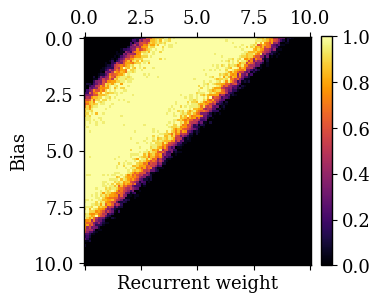

In [101]:
gabazine_activity_ratio = load_data('data/completion_percentages_50.pickle')
scale = 4
fig, ax = plt.subplots(1, figsize=(1 * scale, 1 * scale))
cbar = ax.matshow(gabazine_activity_ratio, vmax=1, cmap='inferno')
plt.colorbar(cbar, fraction=0.046, pad=0.04)
ax.set_ylabel('Bias')
ax.set_xlabel('Recurrent weight')
ax.set_xticks(np.linspace(0, 99, 5))
ax.set_xticklabels(np.linspace(0, 10, 5))
ax.set_yticks(np.linspace(0, 99, 5))
ax.set_yticklabels(np.linspace(0, 10, 5))

fig.tight_layout()
fig.savefig('paper/reduced_model/completion_percentages.svg')

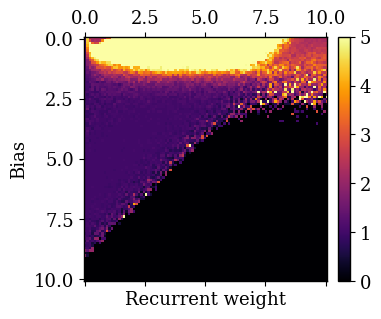

In [102]:
gabazine_activity_ratio = load_data('data/gabazine_activity_ratio.pickle')
scale = 4
fig, ax = plt.subplots(1, figsize=(1 * scale, 1 * scale))
cbar = ax.matshow(gabazine_activity_ratio, vmax=5, cmap='inferno')
plt.colorbar(cbar, fraction=0.046, pad=0.04)
ax.set_ylabel('Bias')
ax.set_xlabel('Recurrent weight')
ax.set_xticks(np.linspace(0, 99, 5))
ax.set_xticklabels(np.linspace(0, 10, 5))
ax.set_yticks(np.linspace(0, 99, 5))
ax.set_yticklabels(np.linspace(0, 10, 5))

fig.tight_layout()
fig.savefig('paper/reduced_model/activity_ratio.svg')


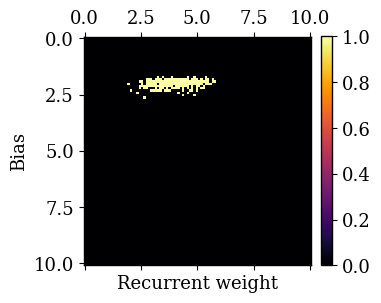

In [103]:
gabazine_activity_ratio = load_data('data/gabazine_activity_ratio.pickle')
completion_percentages = load_data('data/completion_percentages.pickle')
scale = 4
fig, ax = plt.subplots(1, figsize=(1 * scale, 1 * scale))
cbar = ax.matshow(np.logical_and(np.logical_and(gabazine_activity_ratio < 2, gabazine_activity_ratio > 1.2), completion_percentages > 0.9), cmap='inferno')
plt.colorbar(cbar, fraction=0.046, pad=0.04)
ax.set_ylabel('Bias')
ax.set_xlabel('Recurrent weight')
ax.set_xticks(np.linspace(0, 99, 5))
ax.set_xticklabels(np.linspace(0, 10, 5))
ax.set_yticks(np.linspace(0, 99, 5))
ax.set_yticklabels(np.linspace(0, 10, 5))

fig.tight_layout()
fig.savefig('paper/reduced_model/intersection.svg')


In [218]:
w_0 = 10 * np.ones(50)
b = 1
w_r = 5 * np.ones(50)
g = 2
sa, aa, sawbu, ws = run_n_activations(w_0, b, g, w_r, 300)

0
50
100
150
200
250


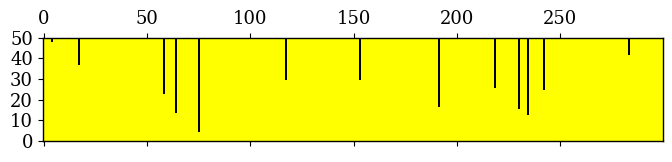

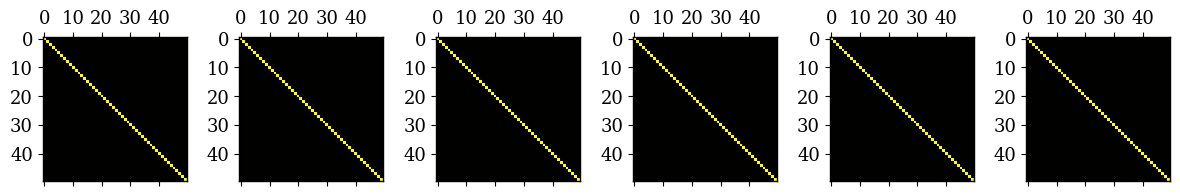

In [219]:
plt.rc('font', family='serif')
plt.rcParams['font.size'] = 13
plt.rcParams['axes.linewidth'] = 1.

scale = 8
fig, ax = plt.subplots(1, figsize=(1 * scale, 1 * scale))
cbar = ax.matshow(sawbu.T, vmax=1, vmin=-1, cmap=activity_colormap)
ax.set_ylim(0, sawbu.shape[1])


scale = 2
r = np.arange(0, aa.shape[0], 50)
fig, ax = plt.subplots(1, len(r), figsize=(len(r) * scale, 1 * scale))
for i, activation_i in enumerate(r):
    print(activation_i)
    cbar = ax[i].matshow(aa[activation_i, :], vmax=1, vmin=-1, cmap=activity_colormap)
fig.tight_layout()

In [202]:
w_0 = 10 * np.ones(50)
b = 2.5
w_r = 3.7 * np.ones(50)
g = 3
sa, aa, sawbu, ws = run_n_activations(w_0, b, g, w_r, 2000, make_w_transform_homeostatic(0.005, 1), make_w_r_transform(0.01, w_r[0]), dropout_iter=10, dropout_func=make_dropout(0.6))

10.0
0
50
100
150
200
250
300
350
400
450
500
550


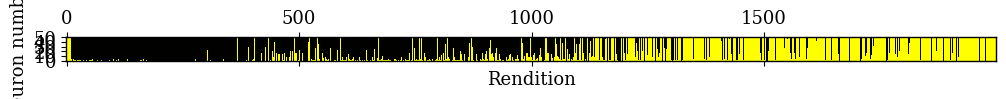

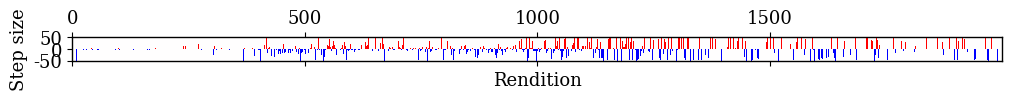

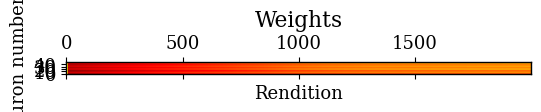

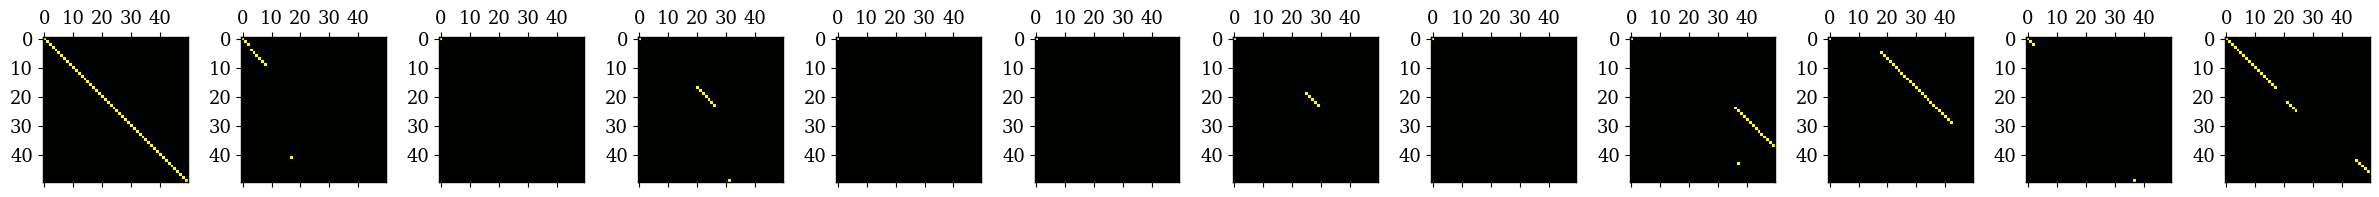

In [203]:
plt.rc('font', family='serif')
plt.rcParams['font.size'] = 13
plt.rcParams['axes.linewidth'] = 1.

scale = 6
fig, ax = plt.subplots(1, figsize=(2 * scale, 1 * scale))
cbar = ax.matshow(sa.T, vmax=1, vmin=-1, cmap=activity_colormap)
# plt.colorbar(cbar)
ax.set_ylim(0, sa.shape[1])
ax.set_ylabel('Neuron number')
ax.set_xlabel('Rendition')
fig.savefig('paper/reduced_model/ex_homeo_recovery.svg')

scale = 6
fig, ax = plt.subplots(1, figsize=(2 * scale, 1 * scale))
steps = np.zeros((sa.shape[0], 2 * sa.shape[1] + 1))
all_lens = extract_lengths_bulk([sa])
len_diffs = all_lens[0][1:] - all_lens[0][:-1]
for i_ld, ld in enumerate(len_diffs):
    if ld > 0:
        steps[i_ld, 50:50 + int(ld)] = 1
    else:
        steps[i_ld, 50 + int(ld):50] = -1

cbar = ax.matshow(steps.T, vmax=1, vmin=-1, cmap='bwr', aspect=0.5)
# plt.colorbar(cbar)
ax.set_ylim(0, 2 * sa.shape[1] + 1)
ax.set_ylabel('Step size')
ax.set_xlabel('Rendition')
ax.set_yticks([0, 50, 101])
ax.set_yticklabels([-50, 0, 50])
fig.savefig('paper/reduced_model/ex_homeo_recovery_steps.svg')

fig, ax = plt.subplots(1, figsize=(1 * scale, 1 * scale))
cbar = ax.matshow(ws.T, cmap='hot', vmin=0, vmax=15)
print(ws.max())
# plt.colorbar(cbar)
ax.set_ylim(0, ws.shape[1] - 1)
ax.set_ylabel('Neuron number')
ax.set_xlabel('Rendition')
ax.set_title('Weights')

scale = 2
r = np.arange(0, 600, 50)
fig, ax = plt.subplots(1, len(r), figsize=(len(r) * scale, 1 * scale))
for i, activation_i in enumerate(r):
    print(activation_i)
    cbar = ax[i].matshow(aa[activation_i, :], vmax=1, vmin=-1, cmap=activity_colormap)
fig.tight_layout()

In [174]:
w_0 = 10 * np.ones(50)
b = 2.5
w_r = 3.7 * np.ones(50)
g = 3
sas_for_activations = []
sa, aa, sawbu, ws = run_n_activations(w_0, b, g, w_r, 1000, make_w_transform_seq(0.1, 10), make_w_r_transform(0.01, w_r[0]), dropout_iter=10, dropout_func=make_dropout(0.6))
sas_for_activations.append(sawbu)

10.0
0
50
100
150
200
250
300
350
400
450
500
550


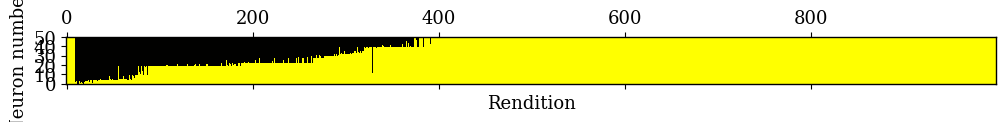

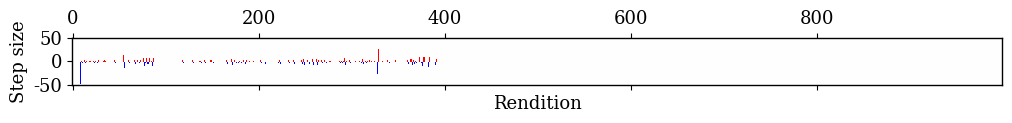

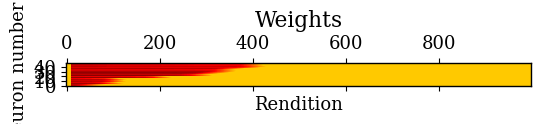

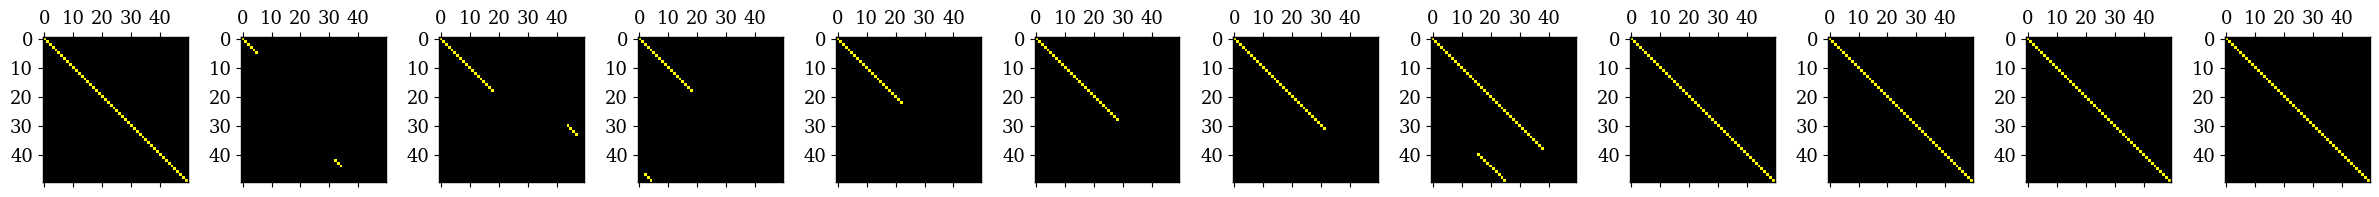

In [175]:
plt.rc('font', family='serif')
plt.rcParams['font.size'] = 13
plt.rcParams['axes.linewidth'] = 1.

scale = 6
fig, ax = plt.subplots(1, figsize=(2 * scale, 1 * scale))
cbar = ax.matshow(sa.T, vmax=1, vmin=-1, cmap=activity_colormap)
# plt.colorbar(cbar)
ax.set_ylim(0, sa.shape[1])
ax.set_ylabel('Neuron number')
ax.set_xlabel('Rendition')
fig.savefig('paper/reduced_model/ex_stdp_recovery.svg')

scale = 6
fig, ax = plt.subplots(1, figsize=(2 * scale, 1 * scale))
steps = np.zeros((sa.shape[0], 2 * sa.shape[1] + 1))
all_lens = extract_lengths_bulk([sa])
len_diffs = all_lens[0][1:] - all_lens[0][:-1]
for i_ld, ld in enumerate(len_diffs):
    if ld > 0:
        steps[i_ld, 50:50 + int(ld)] = 1
    else:
        steps[i_ld, 50 + int(ld):50] = -1

cbar = ax.matshow(steps.T, vmax=1, vmin=-1, cmap='bwr', aspect=0.5)
# plt.colorbar(cbar)
ax.set_ylim(0, 2 * sa.shape[1] + 1)
ax.set_ylabel('Step size')
ax.set_xlabel('Rendition')
ax.set_yticks([0, 50, 101])
ax.set_yticklabels([-50, 0, 50])
fig.savefig('paper/reduced_model/ex_stdp_recovery_steps.svg')

fig, ax = plt.subplots(1, figsize=(1 * scale, 1 * scale))
cbar = ax.matshow(ws.T, cmap='hot', vmin=0, vmax=15)
print(ws.max())
# plt.colorbar(cbar)
ax.set_ylim(0, ws.shape[1] - 1)
ax.set_ylabel('Neuron number')
ax.set_xlabel('Rendition')
ax.set_title('Weights')

scale = 2
r = np.arange(0, 600, 50)
fig, ax = plt.subplots(1, len(r), figsize=(len(r) * scale, 1 * scale))
for i, activation_i in enumerate(r):
    print(activation_i)
    cbar = ax[i].matshow(aa[activation_i, :], vmax=1, vmin=-1, cmap=activity_colormap)
fig.tight_layout()

In [186]:
w_0 = 10 * np.ones(50)
b = 2.5
w_r = 3.7 * np.ones(50)
g = 3
sas_for_activations = []
sa, aa, sawbu, ws = run_n_activations(w_0, b, g, w_r, 1000, make_w_transform_seq_w(0.1, 10), make_w_r_transform(0.01, w_r[0]), dropout_iter=10, dropout_func=make_dropout(0.6))
sas_for_activations.append(sawbu)

10.0
0
50
100
150
200
250
300
350
400
450
500
550


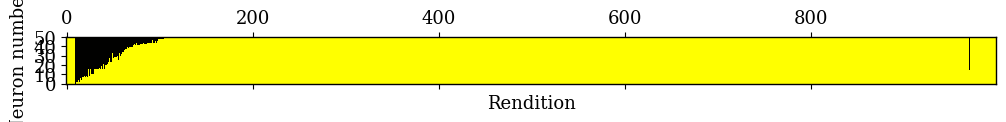

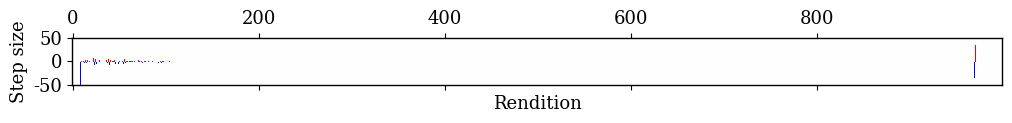

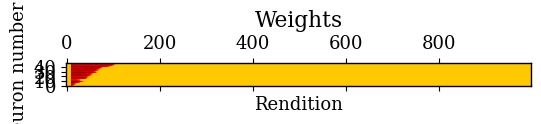

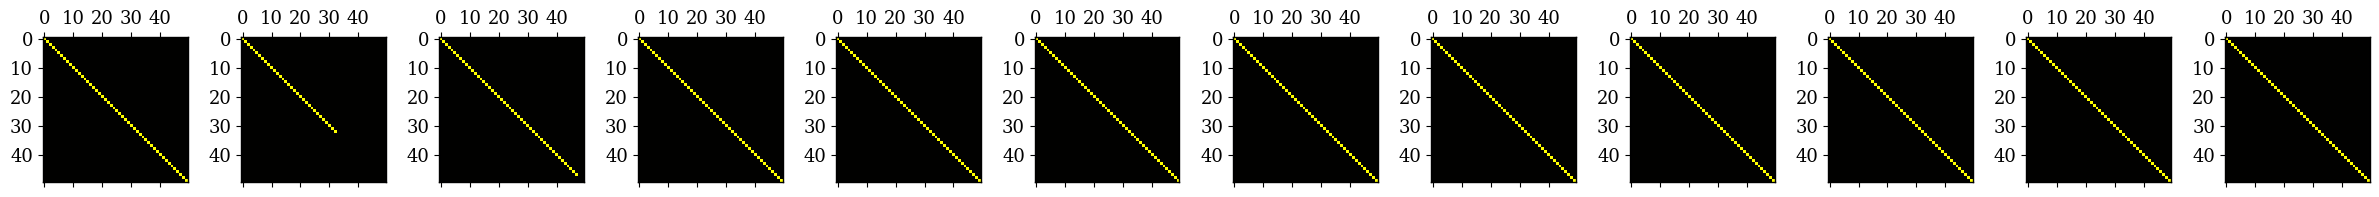

In [187]:
plt.rc('font', family='serif')
plt.rcParams['font.size'] = 13
plt.rcParams['axes.linewidth'] = 1.

scale = 6
fig, ax = plt.subplots(1, figsize=(2 * scale, 1 * scale))
cbar = ax.matshow(sa.T, vmax=1, vmin=-1, cmap=activity_colormap)
# plt.colorbar(cbar)
ax.set_ylim(0, sa.shape[1])
ax.set_ylabel('Neuron number')
ax.set_xlabel('Rendition')
fig.savefig('paper/reduced_model/ex_stdp_recovery.svg')

scale = 6
fig, ax = plt.subplots(1, figsize=(2 * scale, 1 * scale))
steps = np.zeros((sa.shape[0], 2 * sa.shape[1] + 1))
all_lens = extract_lengths_bulk([sa])
len_diffs = all_lens[0][1:] - all_lens[0][:-1]
for i_ld, ld in enumerate(len_diffs):
    if ld > 0:
        steps[i_ld, 50:50 + int(ld)] = 1
    else:
        steps[i_ld, 50 + int(ld):50] = -1

cbar = ax.matshow(steps.T, vmax=1, vmin=-1, cmap='bwr', aspect=0.5)
# plt.colorbar(cbar)
ax.set_ylim(0, 2 * sa.shape[1] + 1)
ax.set_ylabel('Step size')
ax.set_xlabel('Rendition')
ax.set_yticks([0, 50, 101])
ax.set_yticklabels([-50, 0, 50])
fig.savefig('paper/reduced_model/ex_stdp_recovery_steps.svg')

fig, ax = plt.subplots(1, figsize=(1 * scale, 1 * scale))
cbar = ax.matshow(ws.T, cmap='hot', vmin=0, vmax=15)
print(ws.max())
# plt.colorbar(cbar)
ax.set_ylim(0, ws.shape[1] - 1)
ax.set_ylabel('Neuron number')
ax.set_xlabel('Rendition')
ax.set_title('Weights')

scale = 2
r = np.arange(0, 600, 50)
fig, ax = plt.subplots(1, len(r), figsize=(len(r) * scale, 1 * scale))
for i, activation_i in enumerate(r):
    print(activation_i)
    cbar = ax[i].matshow(aa[activation_i, :], vmax=1, vmin=-1, cmap=activity_colormap)
fig.tight_layout()

In [1]:
# for dropout_i in range(len(X_across_dropouts)):
    
#     X_parallel, X_seq = X_across_dropouts[dropout_i]
        
#     hitting_times_seq = extract_first_hitting_times(X_seq, [25, 37, 50])
#     hitting_times_parallel = extract_first_hitting_times(X_parallel, [25, 37, 50])
    
#     scale = 4
#     fig, ax = plt.subplots(1, figsize=(1 * scale, 1 * scale))
    
#     ax.plot(np.arange(300), np.arange(300), '--', lw=1, alpha=0.5, color='gray')
    
#     hitting_times_seq = hitting_times_seq[hitting_times_seq[:, 0] > 0, :]
#     hitting_time_seq_partial = hitting_times_seq[:, 1] - hitting_times_seq[:, 0]
#     hitting_time_seq_full = hitting_times_seq[:, 2] - hitting_times_seq[:, 0]
    
#     ax.scatter(hitting_times_seq[:, 1] - hitting_times_seq[:, 0], hitting_times_seq[:, 2] - hitting_times_seq[:, 0], edgecolor='#02ba45', facecolor='none', marker='o', s=10)
    
#     hitting_times_parallel = hitting_times_parallel[hitting_times_parallel[:, 0] > 0, :]
#     hitting_time_parallel_partial = hitting_times_parallel[:, 1] - hitting_times_parallel[:, 0]
#     hitting_time_parallel_full = hitting_times_parallel[:, 2] - hitting_times_parallel[:, 0]
#     ax.scatter(hitting_times_parallel[:, 1] - hitting_times_parallel[:, 0], hitting_times_parallel[:, 2] - hitting_times_parallel[:, 0], edgecolor='blue', facecolor='none', marker='o', s=10)

#     ax.set_xlabel('Recovery time, 3rd quarter')
#     ax.set_ylabel('Recovery time, 2nd half')
    
#     max_time = np.nanmax(np.concatenate([hitting_time_seq_partial, hitting_time_seq_full, hitting_time_parallel_partial, hitting_time_parallel_full]))
#     ax.set_xlim(0, 1.1 * max_time)
#     ax.set_ylim(0, 1.1 * max_time)

In [1062]:
# r_squareds_parallel = []
# r_squareds_seq = []

# for dropout_i in range(len(X_across_dropouts)):
    
#     X_parallel, X_seq = X_across_dropouts[dropout_i]
    
#     hitting_times_parallel = extract_first_hitting_times(X_parallel, np.arange(1, 51))
#     hitting_times_seq = extract_first_hitting_times(X_seq, np.arange(1, 51))
    
#     r_values_parallel = []
#     for i in range(len(hitting_times_parallel)):
#         if (hitting_times_parallel[i] != 0).any() and (hitting_times_parallel[i][-1] > 0 or np.isnan(hitting_times_parallel[i][-1])):
#             slope, intercept, r_value, p_value, std_err = linregress(np.arange(hitting_times_parallel.shape[1]), hitting_times_parallel[i])
#             r_values_parallel.append(np.square(r_value))
     
#     r_values_seq = []
#     for i in range(len(hitting_times_seq)):
#         if (hitting_times_seq[i] != 0).any() and hitting_times_seq[i][-1] > 0:
#             slope, intercept, r_value, p_value, std_err = linregress(np.arange(hitting_times_seq.shape[1]), hitting_times_seq[i])
#             r_values_seq.append(np.square(r_value))
            
#     r_squareds_parallel.append(np.mean(r_values_parallel))
#     r_squareds_seq.append(np.mean(r_values_seq))

In [2]:
# scale = 4
# fig, axs = plt.subplots(1, figsize=(1 * scale, 1 * scale))

# axs.plot(dropout_percentages, r_squareds_seq)
# axs.plot(dropout_percentages, r_squareds_parallel)
# axs.set_ylabel('Avg R^2 of linear fit')
# axs.set_xlabel('Dropout percentage')

In [198]:
# def plot_salt_vs_seq_statistics(X_parallel_across_dropouts, X_seq_across_dropouts, subtitle='', plot_runs=False):
#     parallel_broken_count = []
#     parallel_recovered_count = []
#     stdp_broken_count = []
#     stdp_recovered_count = []

#     parallel_seq_count = []
#     parallel_salt_count = []
#     stdp_seq_count = []
#     stdp_salt_count = []


#     for dropout_i in range(len(X_parallel_across_dropouts)):

#         X_parallel, X_seq = X_parallel_across_dropouts[dropout_i], X_seq_across_dropouts[dropout_i]
        
#         recovered_parallel = determine_recovered(X_parallel, n_cells=(np.ones(len(X_parallel)) * 50).astype(int))
#         recovered_seq = determine_recovered(X_seq, n_cells=(np.ones(len(X_seq)) * 50).astype(int))
        
#         hitting_times_parallel = extract_first_hitting_times(X_parallel, np.arange(1, 51))
#         hitting_times_seq = extract_first_hitting_times(X_seq, np.arange(1, 51))

#         max_hitting_time = np.nanmax(np.concatenate([hitting_times_parallel.flatten(), hitting_times_seq.flatten()]))

#         all_jumps_parallel = extract_jumps(X_parallel)
#         all_jumps_seq = extract_jumps(X_seq)
        
        
#         if plot_runs:
#             scale = 7
#             fig, axs = plt.subplots(2, 2, figsize=(1 * scale, 1 * scale))

#         seq_count = 0
#         salt_count = 0

#         broken_count = 0
#         recovered_count = 0

#         plotted_count_seq = 0
#         plotted_count_parallel = 0

#         for i in range(len(hitting_times_parallel)):
#             cropped_hitting_time = shave_front_zeros_except_last(hitting_times_parallel[i])
#             recovered = recovered_parallel[i]

#             if np.isnan(hitting_times_parallel[i]).any() or hitting_times_parallel[i][-1] > 0:
#                 broken_count += 1

#             if cropped_hitting_time.shape[0] > 0 and recovered:
#                 recovered_count += 1
#                 activation_lengths = np.arange(51 - cropped_hitting_time.shape[0], 51)
#                 if all_jumps_parallel[i][25:].sum() == 0:  
#                     if plotted_count_seq < 5:
#                         if plot_runs:
#                             axs[0, 1].plot(cropped_hitting_time, activation_lengths, color=rainbow_colors[i])
#                         plotted_count_seq += 1
#                     seq_count += 1
#                 else:
#                     if plotted_count_parallel < 5:
#                         if plot_runs:
#                             axs[0, 0].plot(cropped_hitting_time, activation_lengths, color=rainbow_colors[i])
#                         plotted_count_parallel += 1
#                     salt_count += 1

#         parallel_broken_count.append(broken_count)
#         parallel_recovered_count.append(recovered_count)
#         parallel_seq_count.append(seq_count)
#         parallel_salt_count.append(salt_count)

#         if plot_runs:
#             axs[0, 0].set_title(f'Homeostatic\nsaltatory {salt_count} of {seq_count + salt_count}')
#             axs[0, 1].set_title(f'Homeostatic\nsequential {seq_count} of {seq_count + salt_count}')

#         seq_count = 0
#         salt_count = 0

#         broken_count = 0
#         recovered_count = 0

#         plotted_count_seq = 0
#         plotted_count_parallel = 0

#         for i in range(len(hitting_times_seq)):
#             cropped_hitting_time = shave_front_zeros_except_last(hitting_times_seq[i])
#             recovered = recovered_seq[i]

#             if np.isnan(hitting_times_seq[i]).any() or hitting_times_seq[i][-1] > 0:
#                 broken_count += 1
            
#             if cropped_hitting_time.shape[0] > 0 and recovered:
#                 recovered_count += 1
#                 activation_lengths = np.arange(51 - cropped_hitting_time.shape[0], 51)
#                 if all_jumps_seq[i][25:].sum() == 0:    
#                     if plotted_count_seq < 5:
#                         if plot_runs:
#                             axs[1, 1].plot(cropped_hitting_time, activation_lengths, color=rainbow_colors[i])
#                         plotted_count_seq += 1
#                     seq_count += 1
#                 else:
#                     if plotted_count_parallel < 5:
#                         if plot_runs:
#                             axs[1, 0].plot(cropped_hitting_time, activation_lengths, color=rainbow_colors[i])
#                         plotted_count_parallel += 1
#                     salt_count += 1

#         stdp_broken_count.append(broken_count)
#         stdp_recovered_count.append(recovered_count)
#         stdp_seq_count.append(seq_count)
#         stdp_salt_count.append(salt_count)

#         if plot_runs:
#             axs[1, 0].set_title(f'STDP\nsaltatory {salt_count} of {seq_count + salt_count}')
#             axs[1, 1].set_title(f'STDP\nsequential {seq_count} of {seq_count + salt_count}')

#         if plot_runs:
#             for j in range(2):
#                 for k in range(2):
#                     axs[j, k].set_ylim(0, 50)
#                     if ~np.isnan(max_hitting_time):
#                         axs[j, k].set_xlim(0, max_hitting_time)
#                     axs[j, k].set_ylabel('Activation length')
#                     axs[j, k].set_xlabel('First hitting time')

#             fig.tight_layout()

#     scale = 6
#     fig, axs = plt.subplots(1, 1, figsize=(1.4 * scale, 0.55 * scale))

#     parallel_broken_count = np.array(parallel_broken_count)
#     parallel_recovered_count = np.array(parallel_recovered_count)
#     stdp_broken_count = np.array(stdp_broken_count)
#     stdp_recovered_count = np.array(stdp_recovered_count)

#     axs.bar(np.arange(0, 3 * len(parallel_broken_count), 3), parallel_broken_count, color='white', edgecolor='blue')
#     axs.bar(np.arange(0, 3 * len(parallel_broken_count), 3), parallel_recovered_count, color='blue', edgecolor='blue')
#     axs.bar(np.arange(1, 3 * len(parallel_broken_count) + 1, 3), stdp_broken_count, color='white', edgecolor='#02ba45')
#     axs.bar(np.arange(1, 3 * len(parallel_broken_count) + 1, 3), stdp_recovered_count, color='#02ba45', edgecolor='#02ba45')

#     axs.set_xticks(np.arange(0.5, 3 * len(parallel_broken_count) + 0.5, 3))
#     axs.set_xticklabels(dropout_percentages)

#     axs.set_xlabel('Dropout percentage')
#     axs.set_ylabel('Count')
#     axs.set_title(f'Recovery rates{subtitle}')

#     scale = 6
#     fig, axs = plt.subplots(1, 1, figsize=(1.4 * scale, 0.55 * scale))

#     parallel_seq_count = np.array(parallel_seq_count)
#     parallel_salt_count = np.array(parallel_salt_count)
#     stdp_seq_count = np.array(stdp_seq_count)
#     stdp_salt_count = np.array(stdp_salt_count)

#     axs.bar(np.arange(0, 3 * len(parallel_salt_count), 3), parallel_seq_count + parallel_salt_count, color='white', edgecolor='blue', hatch='//')
#     axs.bar(np.arange(0, 3 * len(parallel_salt_count), 3), parallel_salt_count, color='blue', edgecolor='blue')
#     axs.bar(np.arange(1, 3 * len(parallel_salt_count) + 1, 3), stdp_seq_count + stdp_salt_count, color='white', edgecolor='#02ba45', hatch='//')
#     axs.bar(np.arange(1, 3 * len(parallel_salt_count) + 1, 3), stdp_salt_count, color='#02ba45', edgecolor='#02ba45')

#     axs.set_xticks(np.arange(0.5, 3 * len(parallel_broken_count) + 0.5, 3))
#     axs.set_xticklabels(dropout_percentages)

#     axs.set_xlabel('Dropout percentage')
#     axs.set_ylabel('Count')
#     axs.set_title('Saltatory vs. sequential recovery')

<Figure size 640x480 with 0 Axes>

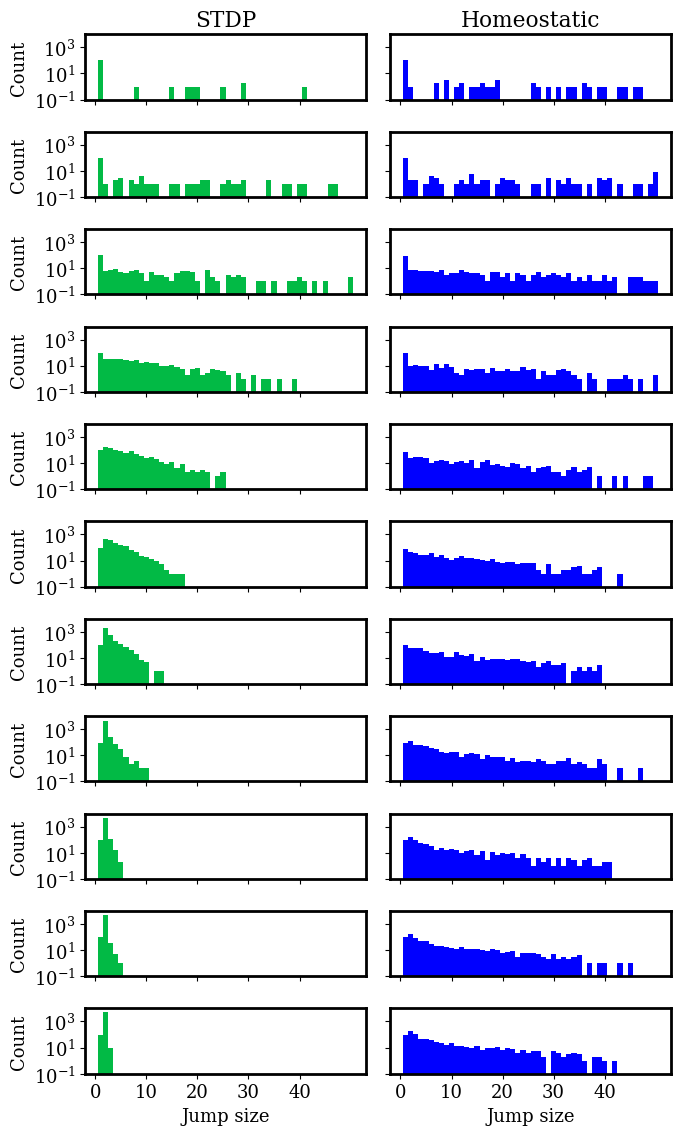

In [1083]:
plt.rc('font', family='serif')
plt.rcParams['font.size'] = 13
plt.rcParams['axes.linewidth'] = 2.
plt.subplots_adjust(wspace=0, hspace=0.05)

scale = 7
fig, axs = plt.subplots(len(X_across_dropouts), 2, figsize=(1 * scale, 0.15 * len(X_across_dropouts) * scale), sharex=True, sharey=True)

for dropout_i in range(len(X_across_dropouts)):
    
    X_parallel, X_seq = X_across_dropouts[dropout_i]
    
    jump_size_counts_parallel = extract_jumps(X_parallel).sum(axis=0)
    jump_size_counts_seq = extract_jumps(X_seq).sum(axis=0)
    
    max_count = np.maximum(np.max(jump_size_counts_parallel), np.max(jump_size_counts_seq))
    
    axs[dropout_i, 0].bar(np.arange(1, len(jump_size_counts_seq) + 1), jump_size_counts_seq, width=1, color='#02ba45')
    axs[dropout_i, 1].bar(np.arange(1, len(jump_size_counts_parallel) + 1), jump_size_counts_parallel, width=1, color='blue')
    
    for i in range(2):
        axs[dropout_i, i].set_yscale('log')
        axs[dropout_i, i].set_xticks(np.arange(0, 50, 10))
        axs[dropout_i, i].set_ylim(1e-1, 2 * max_count)
    
    axs[dropout_i, 0].set_ylabel('Count')
    
axs[0, 0].set_title(f'STDP')
axs[0, 1].set_title(f'Homeostatic')
axs[-1, 0].set_xlabel('Jump size')
axs[-1, 1].set_xlabel('Jump size')
            
fig.tight_layout()

In [11]:
run_name = 'param_sweep_11'

w_0 = 10 * np.ones(50)
dropout_percentages = [0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7]
learning_rates = [0.05, 0.1, 0.2]
inh_learning_rate = 0.01
n_networks = 50
g = 3

In [ ]:
total_points = len(learning_rates) * len(dropout_percentages) * 2
print('total points:', total_points)


df = None
point_count = 0

w_r_0 = 3.7
b = 2.5

w_r = w_r_0 * np.ones(50)

for rate in learning_rates:
    for dropout in dropout_percentages: 
        X_homeo = []
        for i in range(n_networks):
            sa, nsa, sawbu, ws = run_n_activations(w_0, b, g, w_r, 1000,  make_w_transform_homeostatic(rate, 1), make_w_r_transform(inh_learning_rate, w_r_0), dropout_iter=10, dropout_func=make_dropout(dropout))
            X_homeo.append(sawbu)
        X_homeo = np.array(X_homeo)

        data = {
            'rule': ['homeostatic'],
            'rate': [rate],
            'w_r': [w_r_0],
            'b' : [b],
            'dropout': [dropout],
            'activations': [list(X_homeo.flatten().astype(int))],
            'activations_shape': [X_homeo.shape],
        }

        if df is None:
            df = pd.DataFrame(data)
            df.to_csv(f'data/{run_name}.csv', index=False)
        else:
            df = pd.DataFrame(data)
            df.to_csv(f'data/{run_name}.csv', index=False, mode='a', header=False)

        print(point_count)
        point_count += 1


        X_stdp = []
        for i in range(n_networks):
            sa, nsa, sawbu, ws = run_n_activations(w_0, b, g, w_r, 1000, make_w_transform_seq(rate, 10), make_w_r_transform(inh_learning_rate, w_r_0), dropout_iter=10, dropout_func=make_dropout(dropout))
            X_stdp.append(sawbu)
        X_stdp = np.array(X_stdp)

        data = {
            'rule': ['stdp'],
            'rate': [rate],
            'w_r': [w_r_0],
            'b' : [b],
            'dropout': [dropout],
            'activations': [list(X_stdp.flatten().astype(int))],
            'activations_shape': [X_stdp.shape],
        }

        if df is None:
            df = pd.DataFrame(data)
            df.to_csv(f'data/{run_name}.csv', index=False)
        else:
            df = pd.DataFrame(data)
            df.to_csv(f'data/{run_name}.csv', index=False, mode='a', header=False)

        print(point_count)
        point_count += 1

In [13]:
df = pd.read_csv('data/param_sweep_11.csv')

In [230]:
# for i in range(0, len(df), 18):
#     sub_df = df[i:i+18]
#     df_ctrl = sub_df[sub_df['rule'] == 'none']
#     df_homeostatic = sub_df[sub_df['rule'] == 'homeostatic']
#     df_stdp = sub_df[sub_df['rule'] == 'stdp']

#     a_shape = literal_eval(list(df_homeostatic['activations_shape'])[0])
#     w_r = df_homeostatic['w_r'].iloc[0]
#     b = df_homeostatic['b'].iloc[0]
#     rate = df_homeostatic['rate'].iloc[0]

#     activations_ctrl = [np.array(a).reshape(a_shape) for a in list(df_ctrl['activations'].apply(lambda x: json.loads(x)))]
#     activations_homeostatic = [np.array(a).reshape(a_shape) for a in list(df_homeostatic['activations'].apply(lambda x: json.loads(x)))]
#     activations_stdp = [np.array(a).reshape(a_shape) for a in list(df_stdp['activations'].apply(lambda x: json.loads(x)))]

#     plot_salt_vs_seq_statistics(activations_homeostatic, activations_stdp, subtitle=f', w_r={w_r}, b={b}, rate={rate}', plot_runs=True)

In [14]:
def f(X, chain_lengths, chunk_size=10, plot_runs=True):
    plt.rc('font', family='serif')
    plt.rcParams['font.size'] = 13
    plt.rcParams['axes.linewidth'] = 1.
    
    recovered_all = determine_recovered(X, n_cells=chain_lengths)
    lengths_bulk = extract_lengths_bulk(X)
    
    scale = 3
    fig, ax = plt.subplots(1, figsize=(1 * scale, 3 * scale))

    seq_count = 0
    salt_count = 0

    broken_count = 0
    recovered_count = 0

    plotted_count = 0
    plotted_count = 0
    
    all_freqs = None

    for i in range(len(lengths_bulk)):
        recovered = recovered_all[i]
        lengths = lengths_bulk[i]

        if (lengths < chain_lengths[i]).any():
            broken_count += 1

            if recovered:
                aggregated_freqs = []
        
                for j in range(0, lengths.shape[0], chunk_size):
                    bins, freqs = bin_occurrences(lengths[j:j + chunk_size], 0, max_val=np.max(chain_lengths) + 30)
                    aggregated_freqs.append(freqs)
                
                recovered_count += 1
                aggregated_freqs = np.array(aggregated_freqs)
                
                if all_freqs is None:
                    all_freqs = aggregated_freqs
                else:
                    if all_freqs.shape[0] > aggregated_freqs.shape[0]:
                        aggregated_freqs = np.concatenate([aggregated_freqs, np.zeros((all_freqs.shape[0] - aggregated_freqs.shape[0], all_freqs.shape[1]))])
                    elif all_freqs.shape[0] < aggregated_freqs.shape[0]:
                        all_freqs = np.concatenate([all_freqs, np.zeros((aggregated_freqs.shape[0] - all_freqs.shape[0], all_freqs.shape[1]))])
                        
                    all_freqs += aggregated_freqs
    
    # ax.set_ylim(all_freqs.shape[1], 0)           
    ax.matshow(all_freqs.T, aspect=0.2, cmap='hot')
    
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Activation duration')
    
    fig.savefig('paper/reduced_model/duration_dists.svg')
                   

    # parallel_broken_count.append(broken_count)
    # parallel_recovered_count.append(recovered_count)
    # parallel_seq_count.append(seq_count)
    # parallel_salt_count.append(salt_count)

In [1266]:
sas_for_activations = []

w_0 = 10 * np.ones(30)
b = 2.5
w_r = 3.7 * np.ones(30)
g = 2

sa, aa, sawbu, ws = run_n_activations(w_0, b, g, w_r, 600, make_w_transform_seq(0.1, w_0[0]), make_w_r_transform(0.01, w_r[0]), dropout_iter=100, dropout_func=make_dropout(0.6))
sas_for_activations.append(copy(sa))

w_0 = 10 * np.ones(50)
b = 2.5
w_r = 3.7 * np.ones(50)
g = 2

sa, aa, sawbu, ws = run_n_activations(w_0, b, g, w_r, 600, make_w_transform_seq(0.1, w_0[0]), make_w_r_transform(0.01, w_r[0]), dropout_iter=100, dropout_func=make_dropout(0.6))
sas_for_activations.append(copy(sa))

w_0 = 10 * np.ones(80)
b = 2.5
w_r = 3.7 * np.ones(80)
g = 2

sa, aa, sawbu, ws = run_n_activations(w_0, b, g, w_r, 600, make_w_transform_seq(0.1, w_0[0]), make_w_r_transform(0.01, w_r[0]), dropout_iter=100, dropout_func=make_dropout(0.6))
sas_for_activations.append(copy(sa))

w_0 = 10 * np.ones(150)
b = 2.5
w_r = 3.7 * np.ones(150)
g = 2

sa, aa, sawbu, ws = run_n_activations(w_0, b, g, w_r, 600, make_w_transform_seq(0.1, w_0[0]), make_w_r_transform(0.01, w_r[0]), dropout_iter=100, dropout_func=make_dropout(0.6))
sas_for_activations.append(copy(sa))

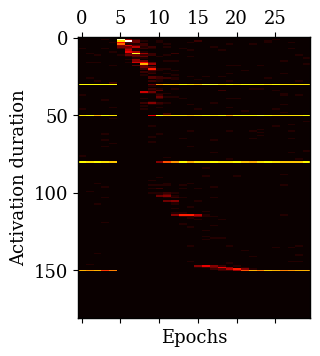

In [1267]:
f(sas_for_activations, [30, 50, 80, 150], chunk_size=20)

In [1272]:
sas_for_activations = []

w_0 = 10 * np.ones(30)
b = 2.5
w_r = 3.7 * np.ones(30)
g = 2

sa, aa, sawbu, ws = run_n_activations(w_0, b, g, w_r, 600, make_w_transform_homeostatic(0.02, w_0[0]), make_w_r_transform(0.005, w_r[0]), dropout_iter=100, dropout_func=make_dropout(0.6))
sas_for_activations.append(copy(sa))

w_0 = 10 * np.ones(50)
b = 2.5
w_r = 3.7 * np.ones(50)
g = 2

sa, aa, sawbu, ws = run_n_activations(w_0, b, g, w_r, 600, make_w_transform_homeostatic(0.02, w_0[0]), make_w_r_transform(0.005, w_r[0]), dropout_iter=100, dropout_func=make_dropout(0.6))
sas_for_activations.append(copy(sa))

w_0 = 10 * np.ones(80)
b = 2.5
w_r = 3.7 * np.ones(80)
g = 2

sa, aa, sawbu, ws = run_n_activations(w_0, b, g, w_r, 600, make_w_transform_homeostatic(0.02, w_0[0]), make_w_r_transform(0.005, w_r[0]), dropout_iter=100, dropout_func=make_dropout(0.6))
sas_for_activations.append(copy(sa))

w_0 = 10 * np.ones(150)
b = 2.5
w_r = 3.7 * np.ones(150)
g = 2

sa, aa, sawbu, ws = run_n_activations(w_0, b, g, w_r, 600, make_w_transform_homeostatic(0.02, w_0[0]), make_w_r_transform(0.005, w_r[0]), dropout_iter=100, dropout_func=make_dropout(0.6))
sas_for_activations.append(copy(sa))

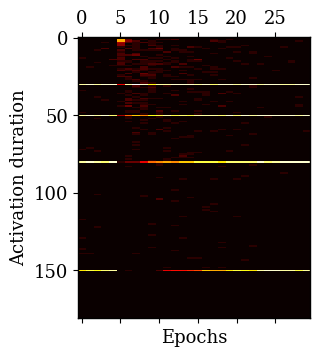

In [1273]:
f(sas_for_activations, [30, 50, 80, 150], chunk_size=20)

In [121]:
def plot_salt_vs_seq_statistics_2(X_parallel_across_dropouts, X_seq_across_dropouts, subtitle='', plot_runs=False, bin_size=50, network_size=50, idx=0):
    parallel_broken_count = []
    parallel_recovered_count = []
    stdp_broken_count = []
    stdp_recovered_count = []

    parallel_jump_count = []
    stdp_jump_count = []
    
    jump_vars = np.array([np.var([p * network_size, 0]) for p in [0, 0.25, 0.5, 0.75]])
    peak_var_max_freq = 0
    
    scale = 7
    fig_len_diffs, axs_len_diffs = plt.subplots(len(X_parallel_across_dropouts), 2, figsize=(1 * scale, 1.6 * scale), sharex=True, sharey=True)
    max_len_diff_count = 0
    fig_peak_vars, axs_peak_vars = plt.subplots(len(X_parallel_across_dropouts), 1, figsize=(0.5 * scale, 1.2 * 9/4 * scale), sharex=True, sharey=True)
        
    for dropout_i in range(len(X_parallel_across_dropouts)):

        X_parallel, X_seq = X_parallel_across_dropouts[dropout_i], X_seq_across_dropouts[dropout_i]
        
        recovered_parallel = determine_recovered(X_parallel, n_cells=(np.ones(len(X_parallel)) * network_size).astype(int))
        recovered_seq = determine_recovered(X_seq, n_cells=(np.ones(len(X_seq)) * network_size).astype(int))
        
        lengths_parallel = extract_lengths_bulk(X_parallel)
        lengths_seq = extract_lengths_bulk(X_seq)
        
        len_diff_counts_parallel, len_diff_sizes = extract_len_diffs(X_parallel, bounds=(-network_size, network_size))
        len_diff_counts_parallel = len_diff_counts_parallel[recovered_parallel.astype(bool)].sum(axis=0).astype(float)
        if recovered_parallel.sum() > 0:
            len_diff_counts_parallel /= recovered_parallel.sum()
        len_diff_counts_parallel[network_size] = 0
        if len_diff_counts_parallel.sum() > 0:
            len_diff_counts_parallel /= len_diff_counts_parallel.sum()
        
        len_diff_counts_seq, len_diff_sizes = extract_len_diffs(X_seq, bounds=(-network_size, network_size))
        len_diff_counts_seq = len_diff_counts_seq[recovered_seq.astype(bool)].sum(axis=0).astype(float)
        if recovered_seq.sum() > 0:
            len_diff_counts_seq /= recovered_seq.sum()
        len_diff_counts_seq[network_size] = 0
        if len_diff_counts_seq.sum() > 0:
            len_diff_counts_seq /= len_diff_counts_seq.sum()
            
        max_len_diff_count = np.max([np.max(len_diff_counts_seq), np.max(len_diff_counts_parallel), max_len_diff_count])
        
        axs_len_diffs[dropout_i, 0].bar(len_diff_sizes, len_diff_counts_seq, width=1, color='#02ba45')
        axs_len_diffs[dropout_i, 1].bar(len_diff_sizes, len_diff_counts_parallel, width=1, color='blue')
        
#         for i in range(2):
#             axs_len_diffs[dropout_i, i].set_yscale('log')
# #             axs[dropout_i, i].set_xticks(np.arange(0, 50, 10))
#             axs_len_diffs[dropout_i, i].set_ylim(1e-1, 2 * max_count)
        
        if plot_runs:
            scale = 7
            fig, axs = plt.subplots(2, 2, figsize=(1 * scale, 1 * scale))
            fig_2, axs_2 = plt.subplots(4, figsize=(0.75 * scale, 1.5 * scale))
            

        jump_count = np.zeros(len(jump_vars))

        broken_count = 0
        recovered_count = 0

        plotted_count_seq = 0
        plotted_count_parallel = 0
        
        homeostatic_vars = []
        stdp_vars = []
        
        var_scale_down = 10

        for i in range(len(lengths_parallel)):
            lengths = lengths_parallel[i][10:]
            recovered = recovered_parallel[i]

            if np.count_nonzero(lengths[:10] < 0.1 * network_size) >= 5:
                broken_count += 1

                if recovered:
                    recovered_count += 1
                    
                    v, v_idx, all_v = extract_max_length_var(lengths, window_size=20)
                    homeostatic_vars.append(v)
                              
                    for i_vj, v_jump in enumerate(jump_vars):
                        if v > v_jump:
                            jump_count[i_vj] += 1
                    
                    if v < np.var([0.75 * network_size, 0]): 
                        if plotted_count_seq < 1:
                            if plot_runs:
                                axs[0, 1].plot(np.arange(len(lengths)), lengths, color=rainbow_colors[i])
            
                                x = np.array([k * np.ones(bin_size) for k in np.arange(0, len(lengths), bin_size)]).flatten()
                                axs_2[0].scatter(x, lengths, marker='o', edgecolor='blue', facecolor='none')
                    
                                axs_2[0].plot(np.arange(10, len(all_v) + 10), all_v / var_scale_down, color='black', lw=0.7)
                            plotted_count_seq += 1
                    else:
                        if plotted_count_parallel < 1:
                            if plot_runs:
                                axs[0, 0].plot(np.arange(len(lengths)), lengths, color=rainbow_colors[i])
                                
                                x = np.array([k * np.ones(bin_size) for k in np.arange(0, len(lengths), bin_size)]).flatten()
                                axs_2[1].scatter(x, lengths, color='blue', marker='o', facecolor='none')
                                
                                axs_2[1].plot(np.arange(10, len(all_v) + 10), all_v / var_scale_down, color='black', lw=0.7)
                            plotted_count_parallel += 1
                        

        parallel_broken_count.append(broken_count)
        parallel_recovered_count.append(recovered_count)
        parallel_jump_count.append(jump_count)

        if plot_runs:
            axs[0, 0].set_title(f'Homeostatic, saltatory')
            axs[0, 1].set_title(f'Homeostatic, sequential')
            
            axs_2[1].set_title(f'Homeostatic, saltatory')
            axs_2[0].set_title(f'Homeostatic, sequential')

        jump_count = np.zeros(len(jump_vars))
        
        broken_count = 0
        recovered_count = 0

        plotted_count_seq = 0
        plotted_count_parallel = 0

        for i in range(len(lengths_seq)):
            lengths = lengths_seq[i][10:]
            recovered = recovered_seq[i]

            if np.count_nonzero(lengths[:10] < 0.1 * network_size) >= 5:
                broken_count += 1

                if recovered:
                    recovered_count += 1
                    
                    v, v_idx, all_v = extract_max_length_var(lengths, window_size=20)
                    stdp_vars.append(v)
                    
                    for i_vj, v_jump in enumerate(jump_vars):
                        if v > v_jump:
                            jump_count[i_vj] += 1

                    if v < np.var([0.75 * network_size, 0]):  
                        if plotted_count_seq < 1:
                            if plot_runs:
                                axs[1, 1].plot(np.arange(len(lengths)), lengths, color=rainbow_colors[i])
                                
                                x = np.array([k * np.ones(bin_size) for k in np.arange(0, len(lengths), bin_size)]).flatten()
                                axs_2[2].scatter(x, lengths, color='#02ba45', marker='o', facecolor='none')
                                
                                axs_2[2].plot(np.arange(10, len(all_v) + 10), all_v / var_scale_down, color='black', lw=0.7)
                            plotted_count_seq += 1
                    else:
                        if plotted_count_parallel < 1:
                            if plot_runs:
                                axs[1, 0].plot(np.arange(len(lengths)), lengths, color=rainbow_colors[i])
                                
                                x = np.array([k * np.ones(bin_size) for k in np.arange(0, len(lengths), bin_size)]).flatten()
                                axs_2[3].scatter(x, lengths, color='#02ba45', marker='o', facecolor='none')
                                
                                axs_2[3].plot(np.arange(10, len(all_v) + 10), all_v / var_scale_down, color='black', lw=0.7)
                            plotted_count_parallel += 1

        stdp_broken_count.append(broken_count)
        stdp_recovered_count.append(recovered_count)
        stdp_jump_count.append(jump_count)

        if plot_runs:
            axs[1, 0].set_title(f'STDP, saltatory')
            axs[1, 1].set_title(f'STDP, sequential')
            
            axs_2[3].set_title(f'STDP, saltatory')
            axs_2[2].set_title(f'STDP, sequential')

        if plot_runs:
            for j in range(2):
                for k in range(2):
#                     axs[j, k].set_ylim(0, 50)
#                     if ~np.isnan(max_hitting_time):
#                         axs[j, k].set_xlim(0, max_hitting_time)
                    axs[j, k].set_ylabel('Activation length')
                    axs[j, k].set_xlabel('Rendition')
            for j in range(4):
                axs_2[j].set_ylabel('Activation length')
                axs_2[j].set_xlabel('Rendition')
                axs_2[j].set_yticks([0, int(network_size/2), network_size])
                secax = axs_2[j].secondary_yaxis('right')
                secax.set_ylabel('Length variance')
                secax.set_yticks([0, int(network_size/2), network_size])
                secax.set_yticklabels([0, int(network_size/2) * var_scale_down, network_size * var_scale_down])

            fig.tight_layout()
            fig_2.tight_layout()
            
            fig_2.savefig(f'paper/reduced_model/var_curves_{idx}_{dropout_i}.svg')
        
        bins, s_freqs = bin_occurrences(np.array(stdp_vars), min_val=0, max_val=800, bin_size=50)
        axs_peak_vars[dropout_i].bar(bins, s_freqs, edgecolor='#02ba45', facecolor='#02ba45', width=50, alpha=0.5)
        
        _, h_freqs = bin_occurrences(np.array(homeostatic_vars), min_val=0, max_val=800, bin_size=50)
        axs_peak_vars[dropout_i].bar(bins, h_freqs, edgecolor='blue', facecolor='blue', width=50, alpha=0.5)
        
        peak_var_max_freq = np.max([peak_var_max_freq, np.max(s_freqs), np.max(h_freqs)])
        
        dashed_line_colors = ['#00ffff', '#ff6600', '#ffcc00']
        for i_ss, step_size in enumerate(np.array([0.25, 0.5, 0.75]) * network_size):
            window_size = 20
            half_window_size = int(window_size / 2)
            var_benchmark = np.var(np.concatenate([np.zeros(half_window_size), step_size * np.ones(window_size - half_window_size)]))
            axs_peak_vars[dropout_i].plot(var_benchmark * np.ones(100), np.arange(0, 100), '--', color=dashed_line_colors[i_ss])

        axs_peak_vars[dropout_i].set_ylabel('Count')
        axs_peak_vars[dropout_i].set_xlim(0, np.var([0, network_size]))
    
    for i_pv in range(len(axs_peak_vars)):
        axs_peak_vars[i_pv].set_ylim(0, peak_var_max_freq * 1.1)
    axs_peak_vars[-1].set_xlabel('Max activation length variance')
    
    fig_len_diffs.tight_layout()
    for k in range(axs_len_diffs.shape[0]):
        for l in range(axs_len_diffs.shape[1]):
            axs_len_diffs[k, l].set_ylim(0, max_len_diff_count)
    axs_len_diffs[-1, 0].set_xlabel('Activation duration change')
    axs_len_diffs[-1, 0].set_ylabel('Probability')
    
    fig_len_diffs.savefig(f'paper/reduced_model/len_diffs_{idx}.svg')
    fig_peak_vars.savefig(f'paper/reduced_model/peak_vars_{idx}.svg')
    
    ### Recovery rates bar graph

    scale = 6
    fig, axs = plt.subplots(1, 1, figsize=(1.4 * scale, 0.55 * scale))

    parallel_broken_count = np.array(parallel_broken_count)
    parallel_recovered_count = np.array(parallel_recovered_count)
    stdp_broken_count = np.array(stdp_broken_count)
    stdp_recovered_count = np.array(stdp_recovered_count)

    axs.bar(np.arange(0, 3 * len(parallel_broken_count), 3), parallel_broken_count, color='white', edgecolor='blue')
    axs.bar(np.arange(0, 3 * len(parallel_broken_count), 3), parallel_recovered_count, color='blue', edgecolor='blue')
    axs.bar(np.arange(1, 3 * len(parallel_broken_count) + 1, 3), stdp_broken_count, color='white', edgecolor='#02ba45')
    axs.bar(np.arange(1, 3 * len(parallel_broken_count) + 1, 3), stdp_recovered_count, color='#02ba45', edgecolor='#02ba45')

    axs.set_xticks(np.arange(0.5, 3 * len(parallel_broken_count) + 0.5, 3))
    axs.set_xticklabels(dropout_percentages)

    axs.set_xlabel('Dropout percentage')
    axs.set_ylabel('Count')
    axs.set_title(f'Recovery rates{subtitle}')
    
    fig.savefig(f'paper/reduced_model/recovery_rates_{idx}.svg')
    
    ### Saltatory vs sequential recovery bar graph

    scale = 6
    fig, axs = plt.subplots(1, 1, figsize=(1.4 * scale, 0.55 * scale))

    parallel_jump_count = np.array(parallel_jump_count)
    stdp_jump_count = np.array(stdp_jump_count)
    
    x_dim = parallel_jump_count[4:, :].shape[0]

    axs.bar(np.arange(0, 3 * x_dim, 3), parallel_jump_count[4:, 0], color='white', edgecolor='blue', hatch='|')
    axs.bar(np.arange(0, 3 * x_dim, 3), parallel_jump_count[4:, 1], color='white', edgecolor='blue')
    axs.bar(np.arange(0, 3 * x_dim, 3), parallel_jump_count[4:, 2],  color='white', edgecolor='blue', hatch='//')
    axs.bar(np.arange(0, 3 * x_dim, 3), parallel_jump_count[4:, 3], color='blue')
    
    print(parallel_recovered_count[4:])
    print(parallel_jump_count[4:, :] / parallel_recovered_count[4:, np.newaxis])
                              
    axs.bar(np.arange(1, 3 * x_dim + 1, 3), stdp_jump_count[4:, 0], color='white', edgecolor='#02ba45', hatch='|')
    axs.bar(np.arange(1, 3 * x_dim + 1, 3), stdp_jump_count[4:, 1], color='white', edgecolor='#02ba45')
    axs.bar(np.arange(1, 3 * x_dim + 1, 3), stdp_jump_count[4:, 2], color='white', edgecolor='#02ba45', hatch='//')
    axs.bar(np.arange(1, 3 * x_dim + 1, 3), stdp_jump_count[4:, 3], color='#02ba45')
    
    print(stdp_recovered_count[4:])
    print(stdp_jump_count[4:, :] / stdp_recovered_count[4:, np.newaxis])

    axs.set_xticks(np.arange(0.5, 3 * x_dim + 0.5, 3))
    axs.set_xticklabels(dropout_percentages[4:])

    axs.set_xlabel('Dropout percentage')
    axs.set_ylabel('Count')
    axs.set_title('Saltatory vs. sequential recovery')
    
    fig.savefig(f'paper/reduced_model/salt_vs_seq_rates_{idx}.svg')

/var/folders/rp/n8h2l6w51774kxnq18z19s8r0000gn/T/ipykernel_3259/2860517722.py:237: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(1, 1, figsize=(1.4 * scale, 0.55 * scale))
/var/folders/rp/n8h2l6w51774kxnq18z19s8r0000gn/T/ipykernel_3259/2860517722.py:282: RuntimeWarning: invalid value encountered in divide
  print(stdp_jump_count[4:, :] / stdp_recovered_count[4:, np.newaxis])


[ 1  5 17 28 37]
[[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]
[ 0  3 14 33  9]
[[       nan        nan        nan        nan]
 [1.         1.         1.         1.        ]
 [1.         1.         0.92857143 0.28571429]
 [1.         1.         0.78787879 0.12121212]
 [1.         1.         0.55555556 0.11111111]]
[ 1  4 23 40 47]
[[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]
[ 0  0  7 37 40]
[[       nan        nan        nan        nan]
 [       nan        nan        nan        nan]
 [1.         1.         1.         0.28571429]
 [1.         1.         0.89189189 0.21621622]
 [1.         1.         0.6        0.075     ]]
[ 0  7 24 36 49]
[[nan nan nan nan]
 [ 1.  1.  1.  1.]
 [ 1.  1.  1.  1.]
 [ 1.  1.  1.  1.]
 [ 1.  1.  1.  1.]]
[ 0  2  6 17 41]
[[       nan        nan        nan        nan]
 [1.         1.         1.         1.        ]
 [1.         1.         1.         1.        ]
 [1.         1.         1.         0.

/var/folders/rp/n8h2l6w51774kxnq18z19s8r0000gn/T/ipykernel_3259/2860517722.py:274: RuntimeWarning: invalid value encountered in divide
  print(parallel_jump_count[4:, :] / parallel_recovered_count[4:, np.newaxis])


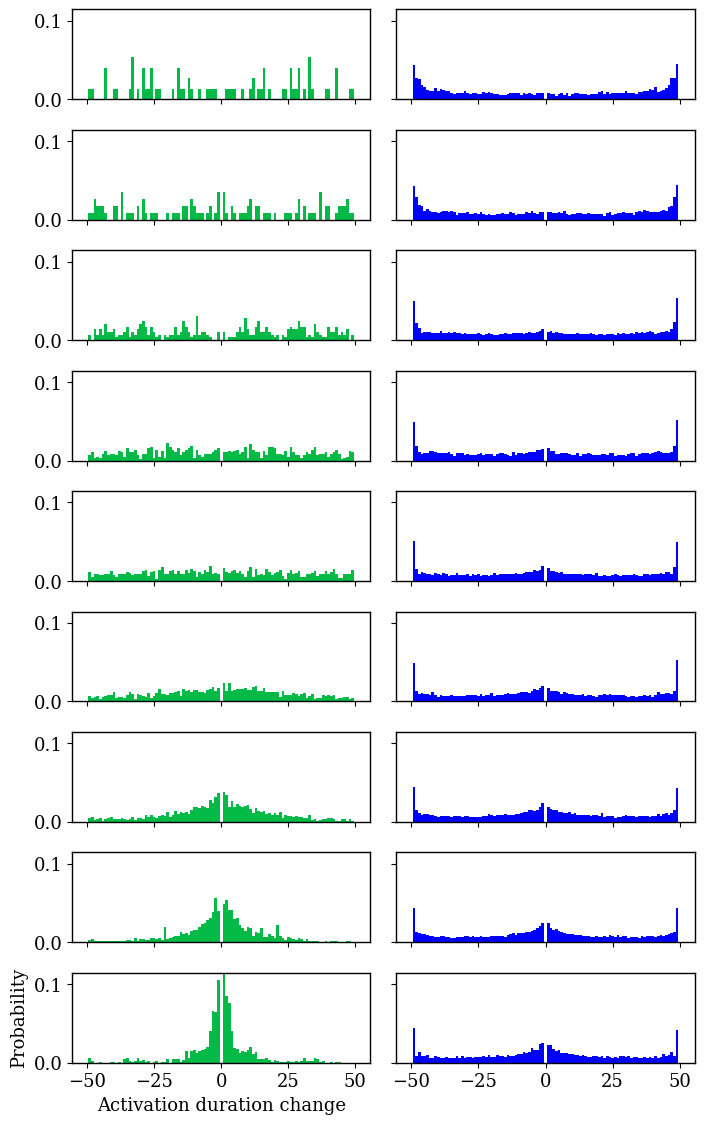

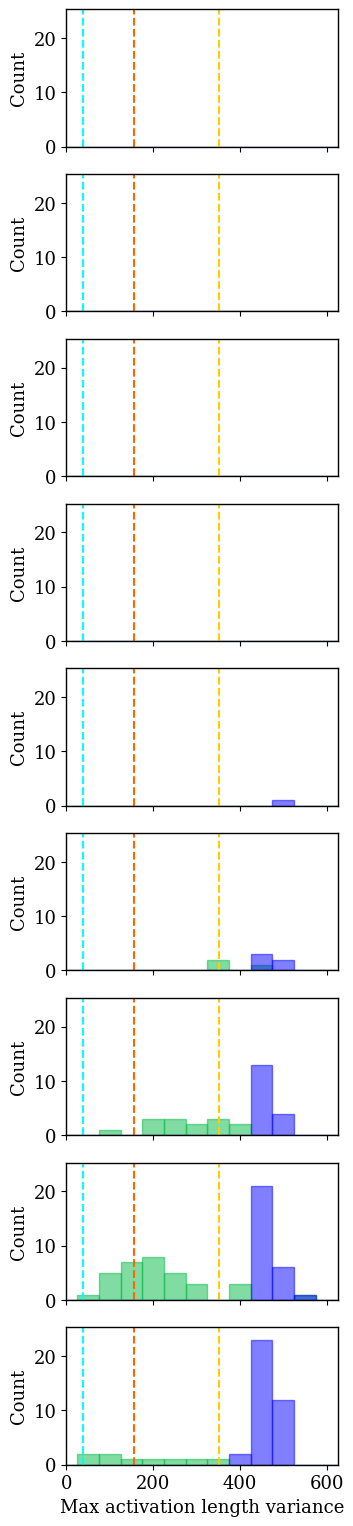

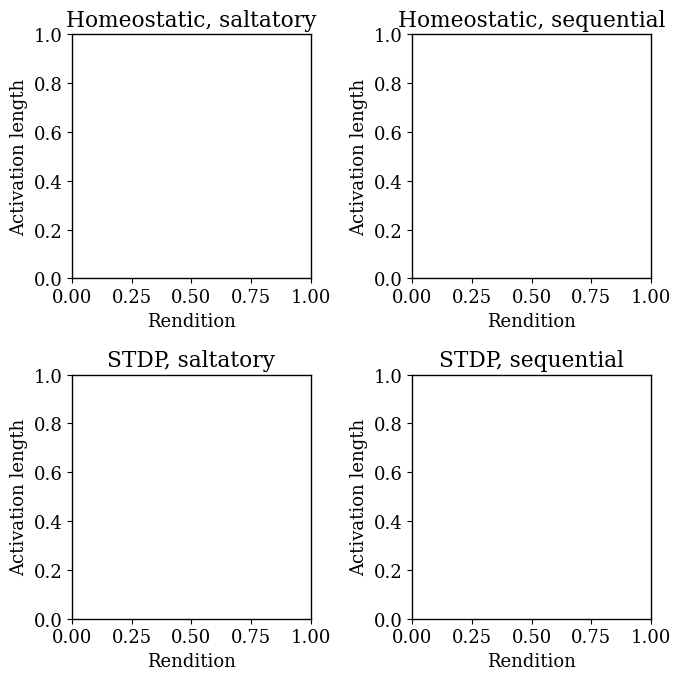

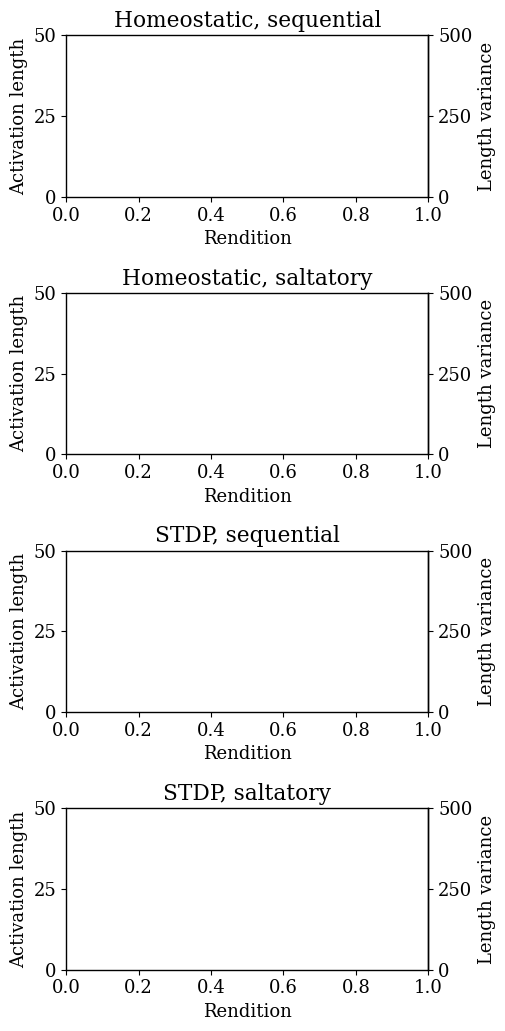

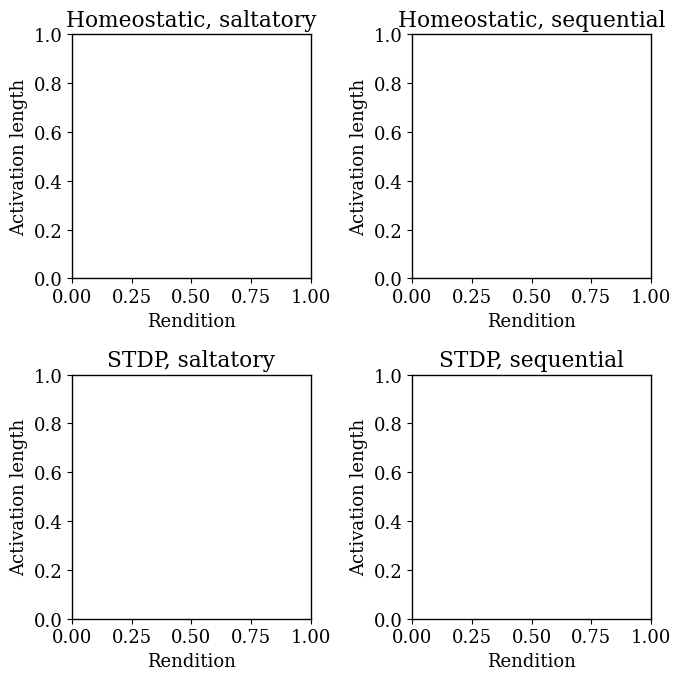

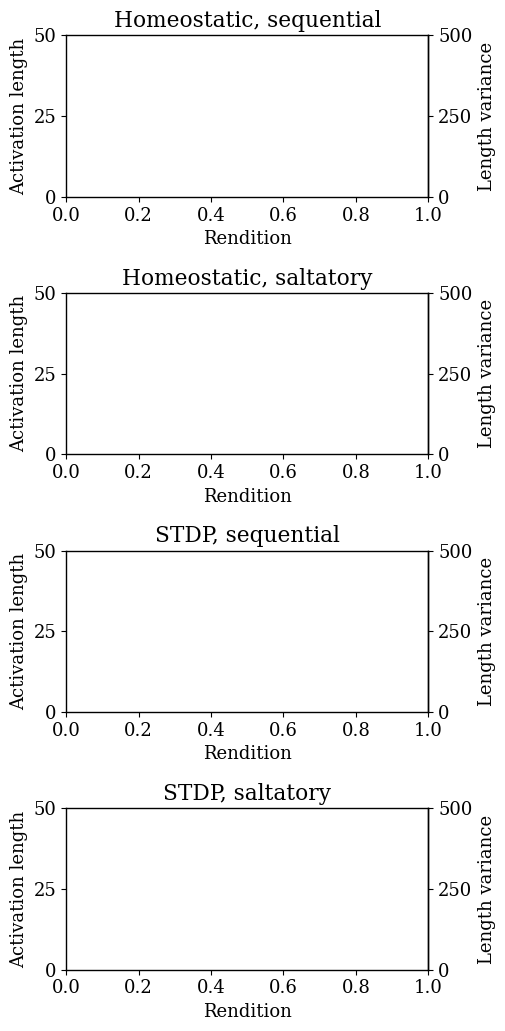

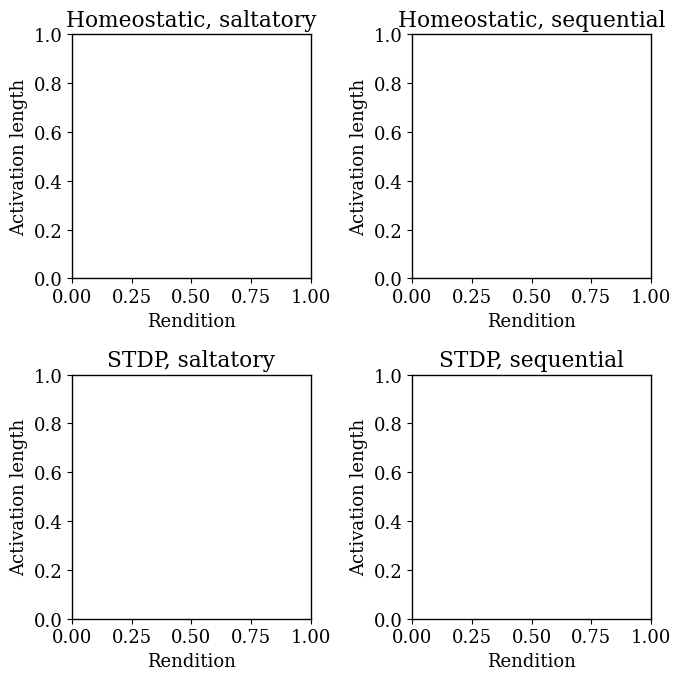

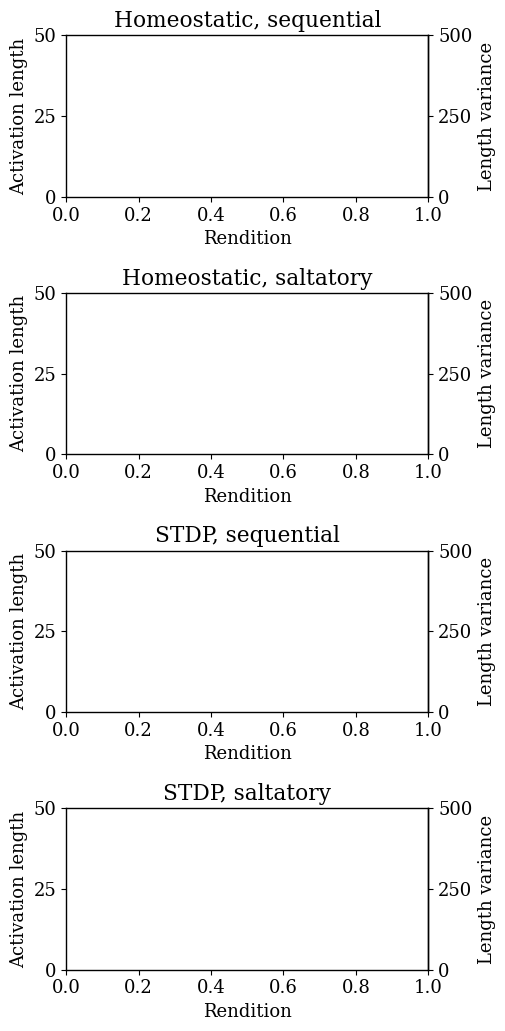

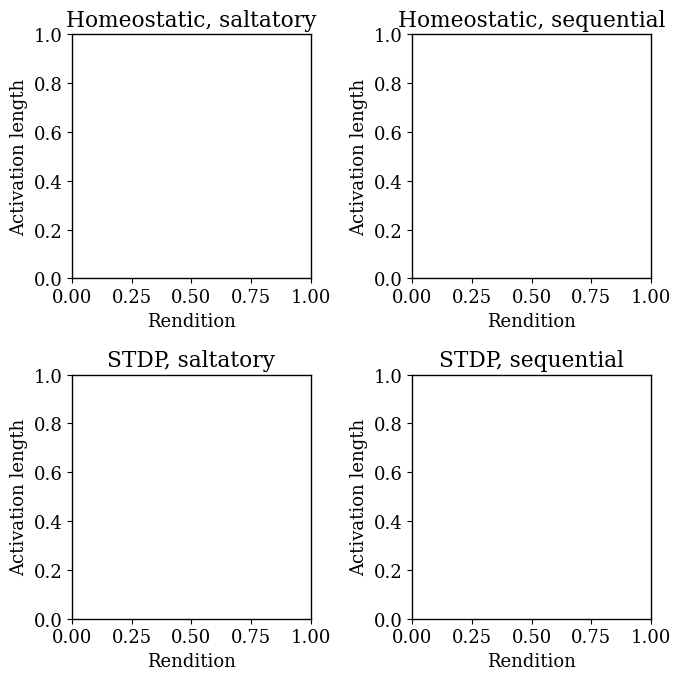

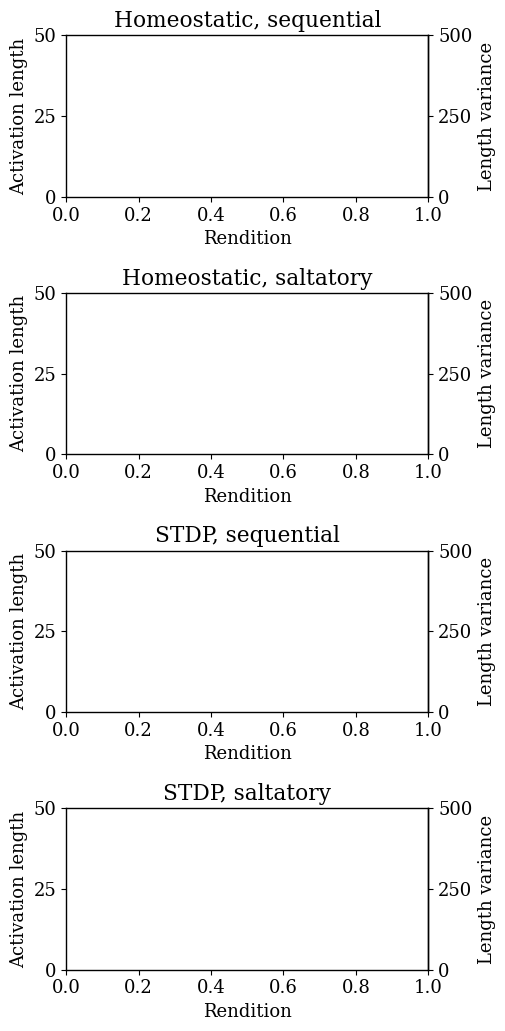

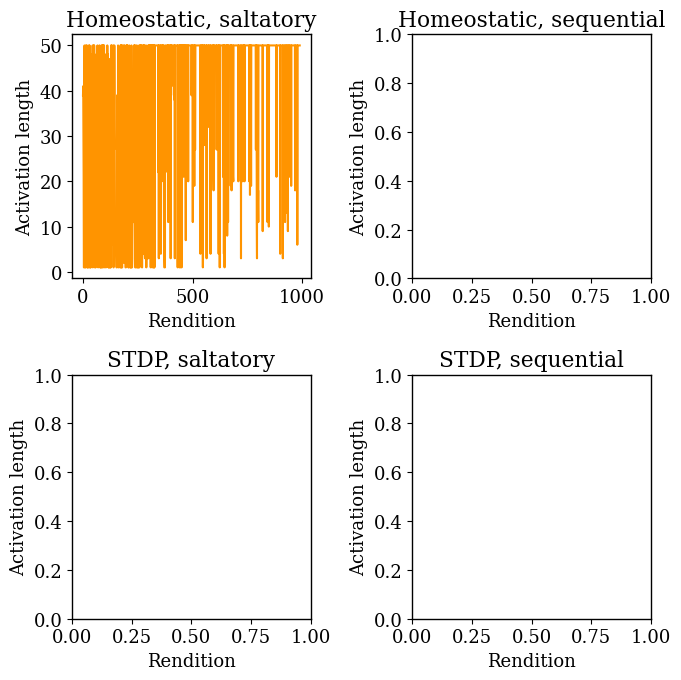

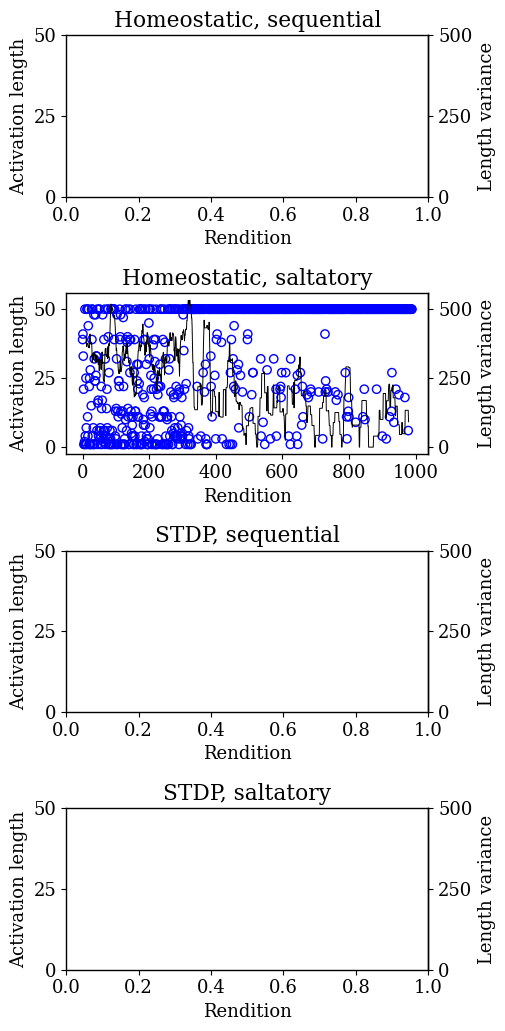

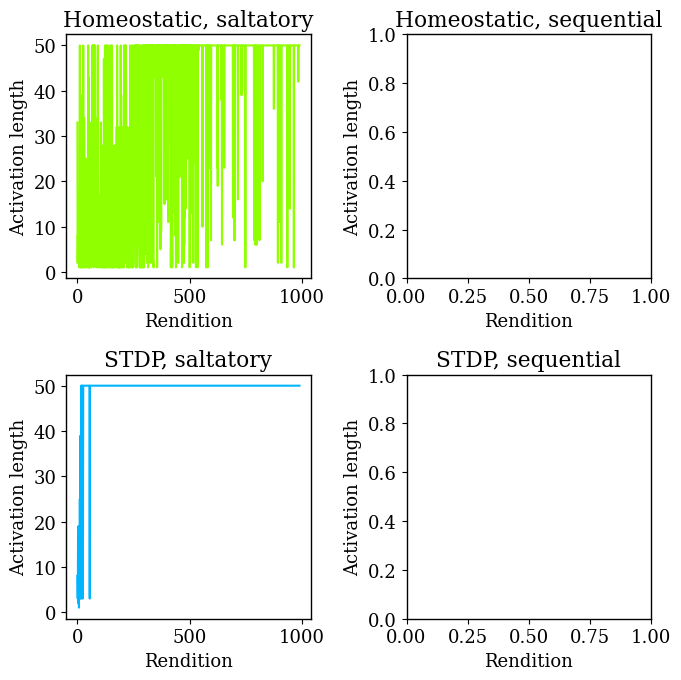

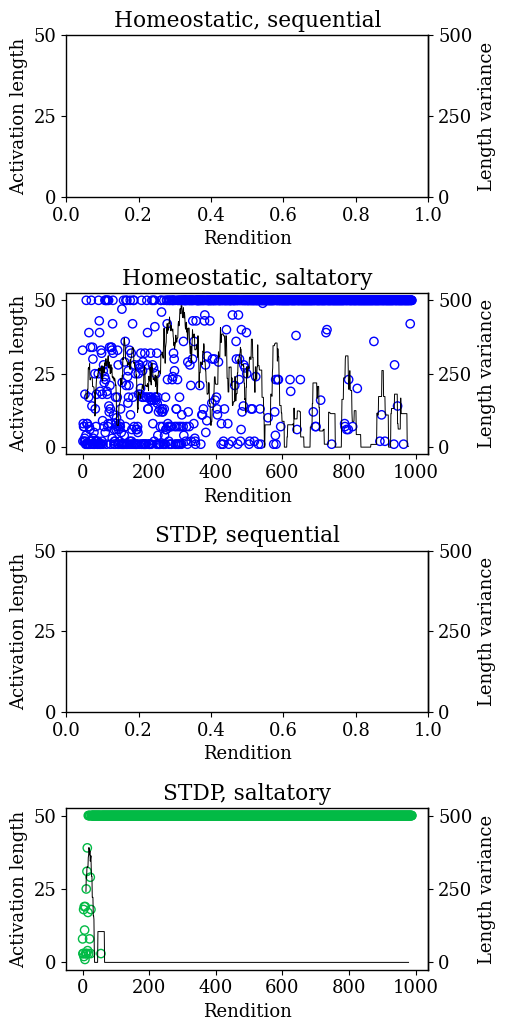

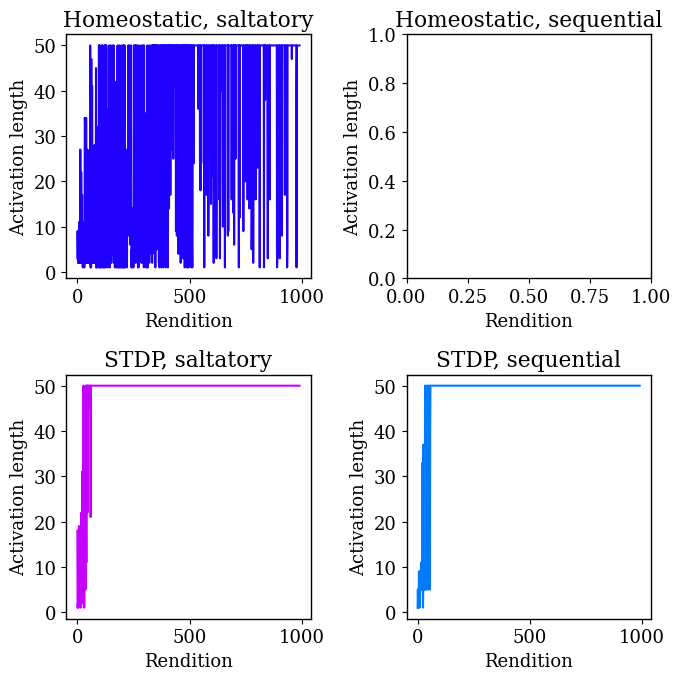

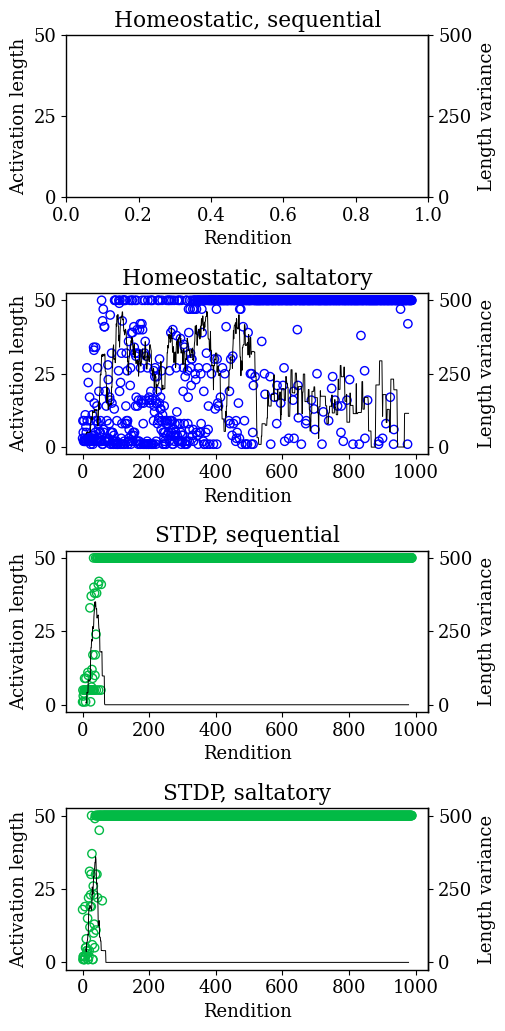

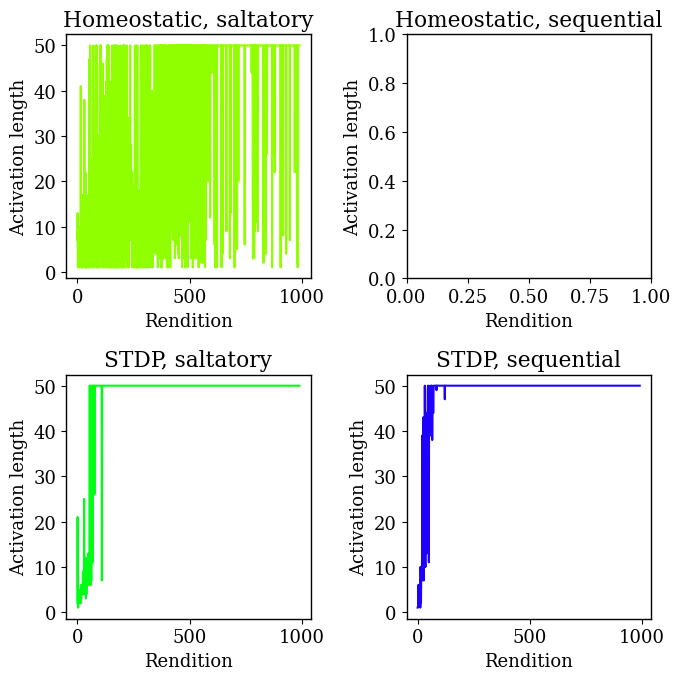

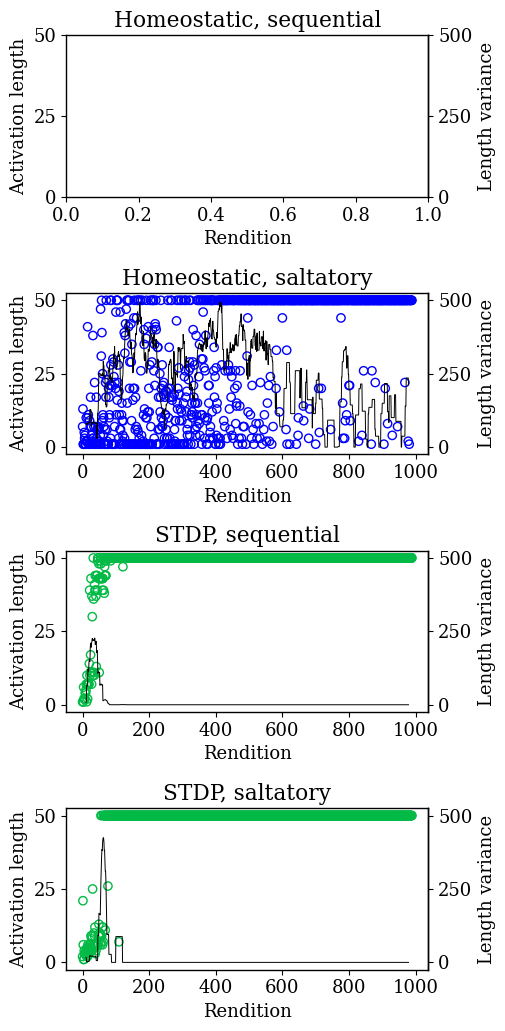

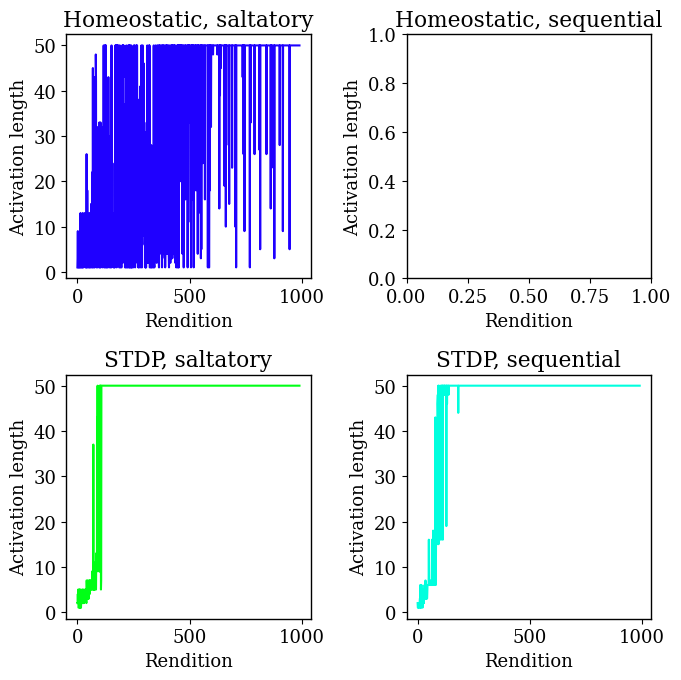

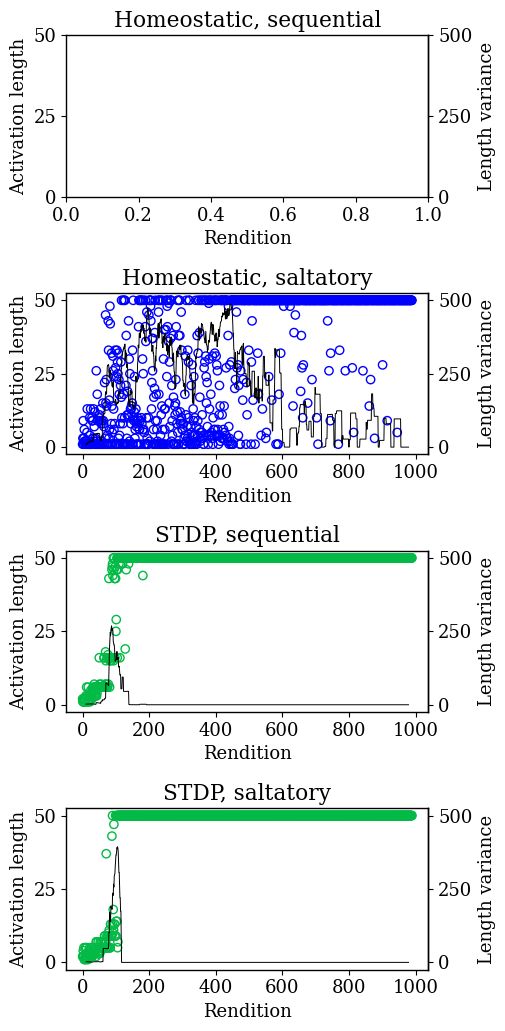

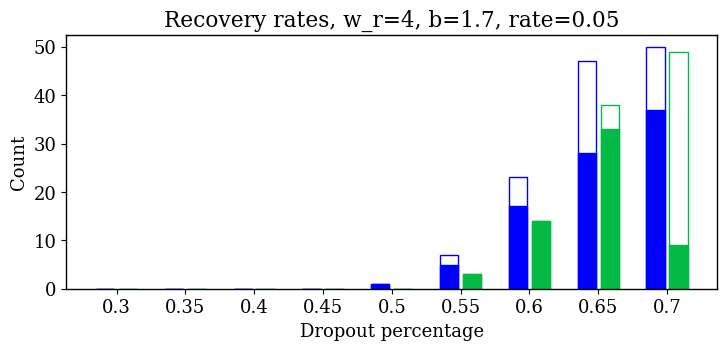

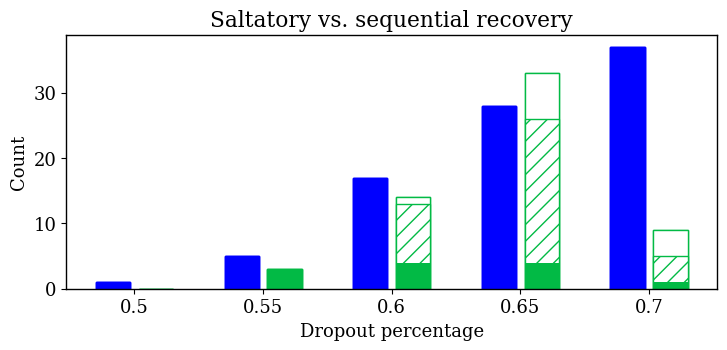

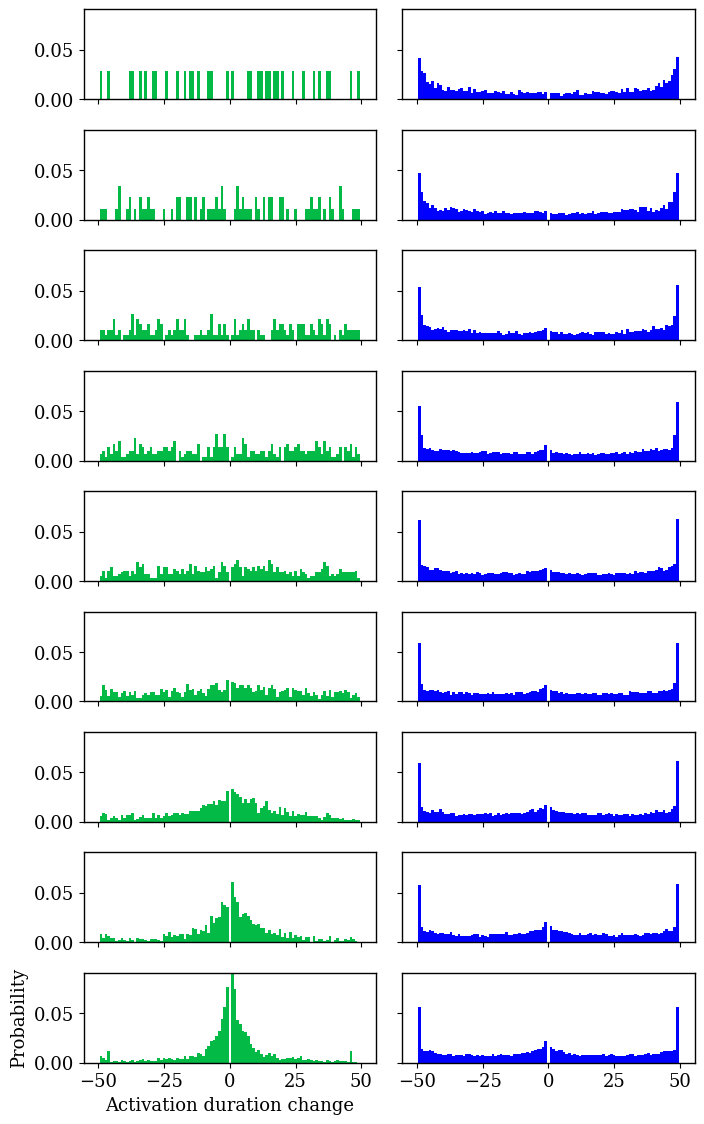

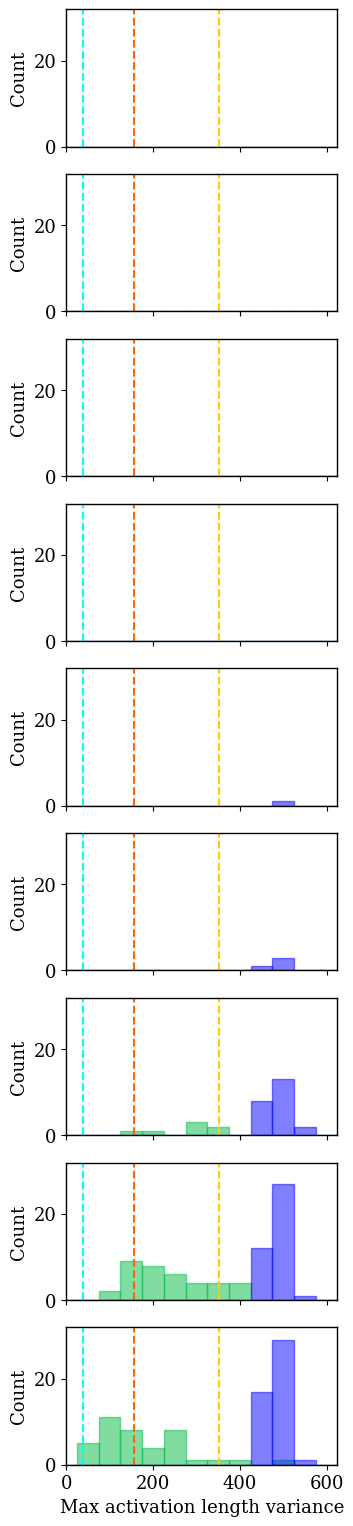

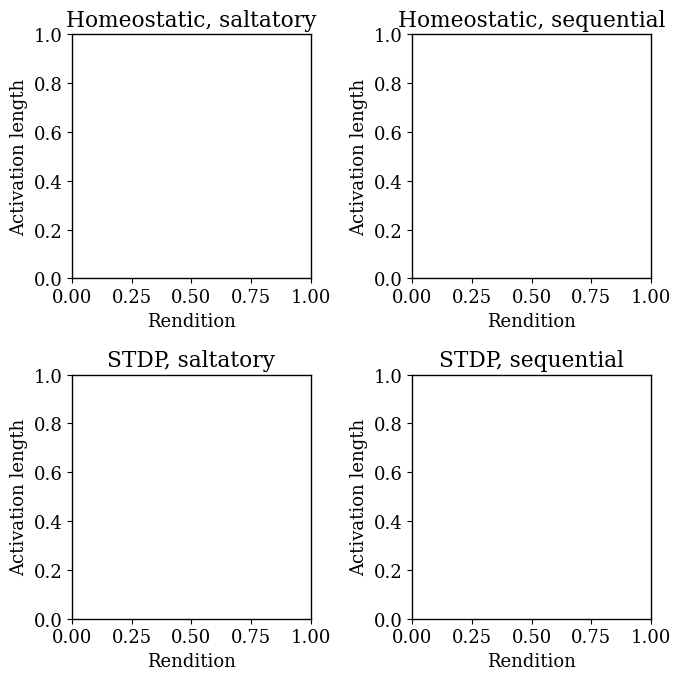

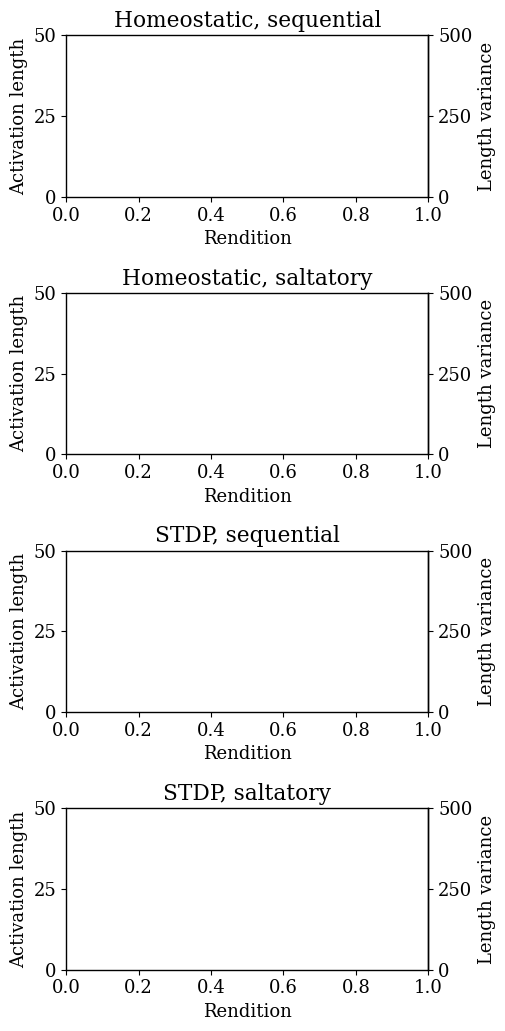

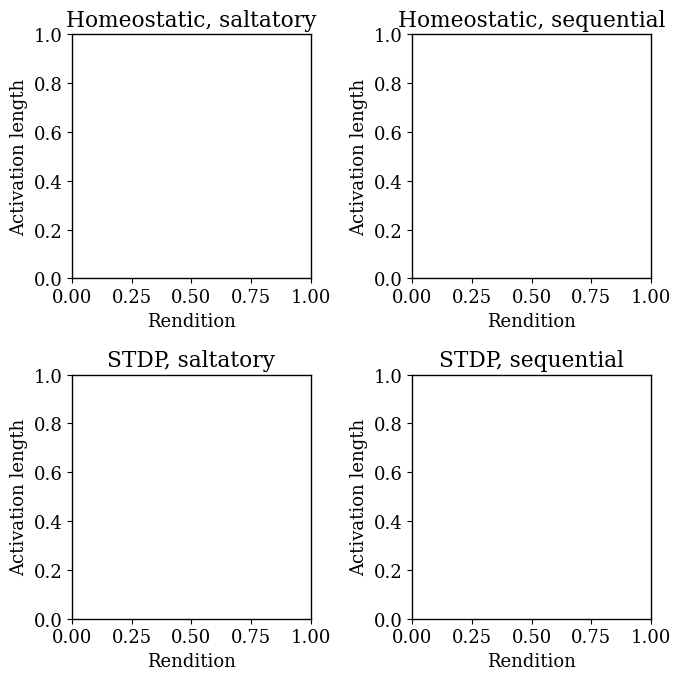

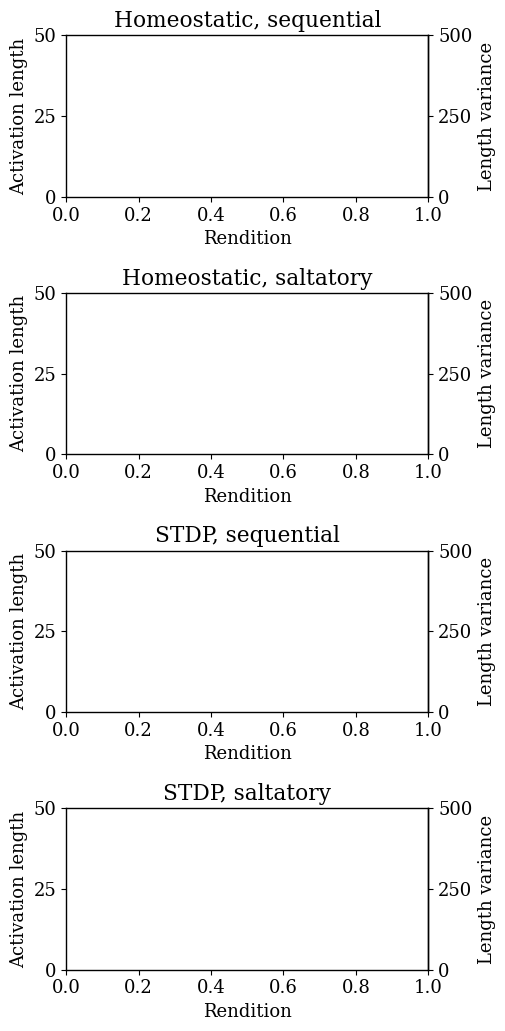

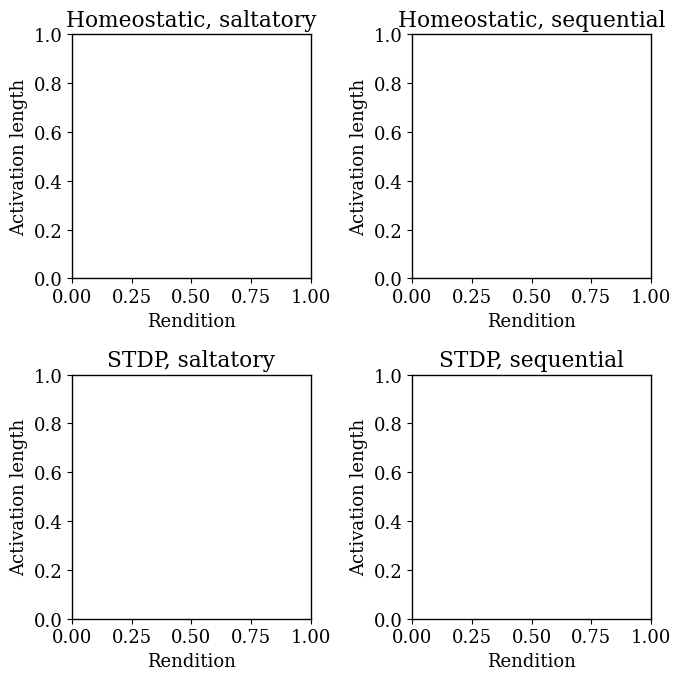

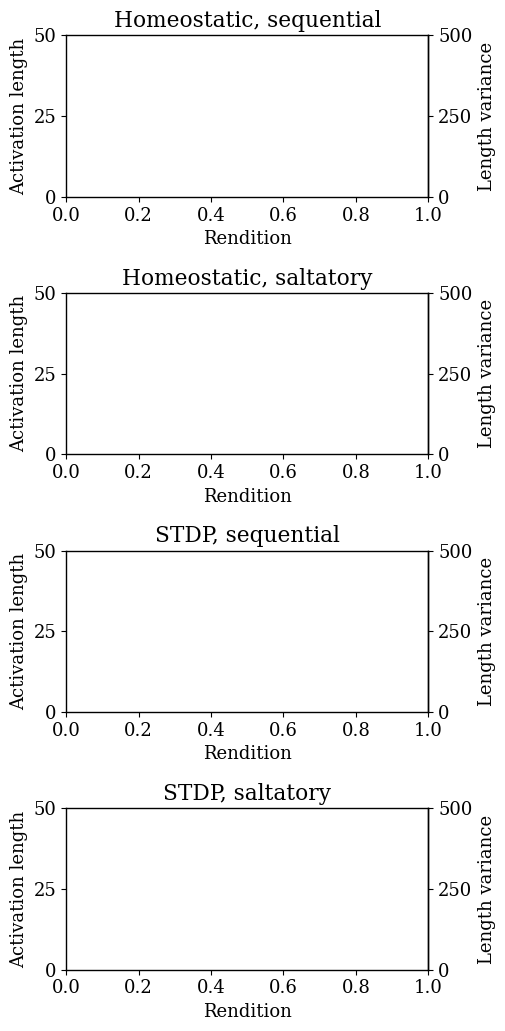

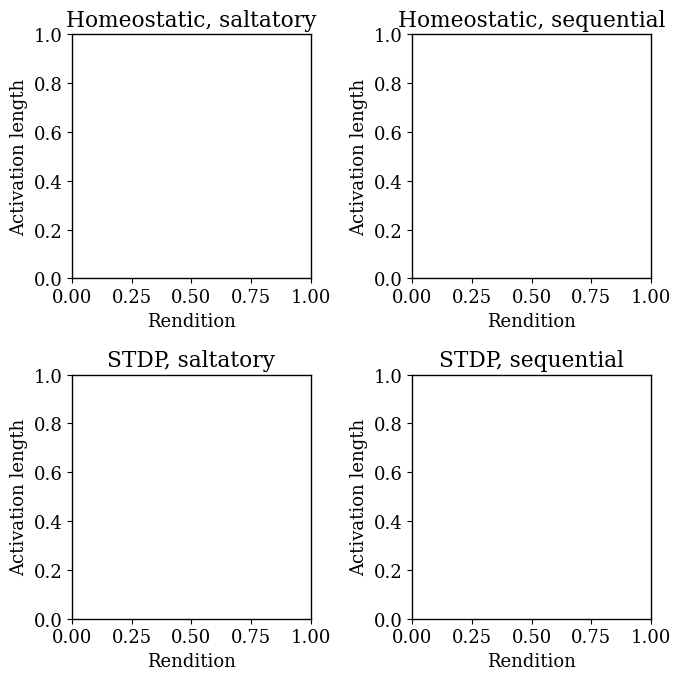

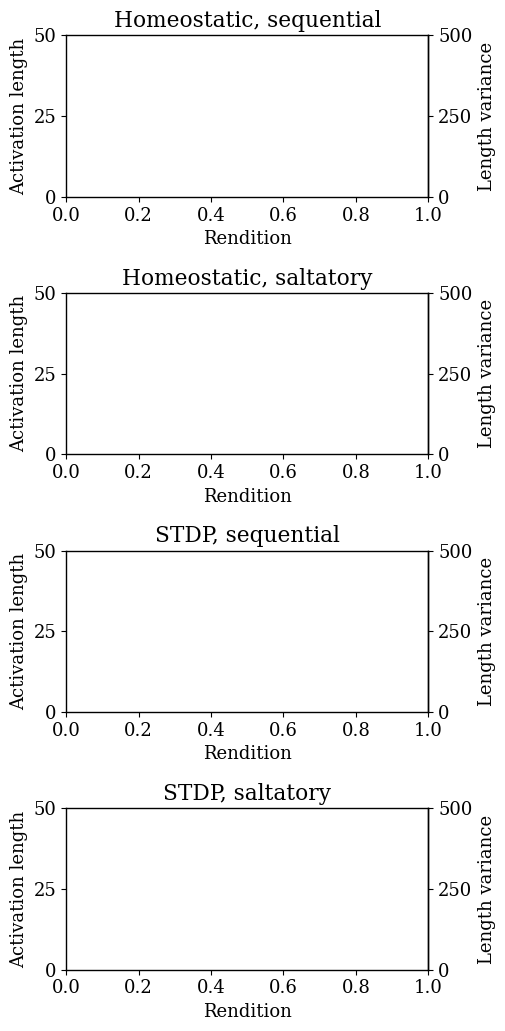

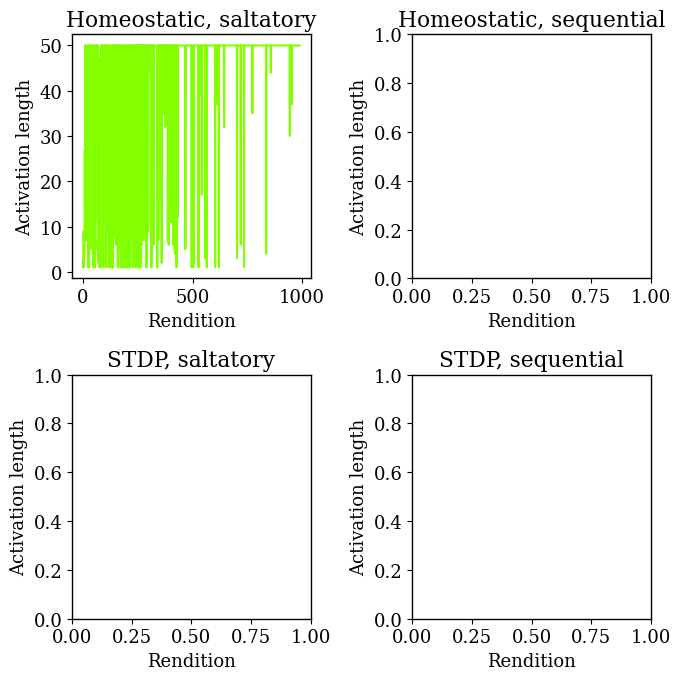

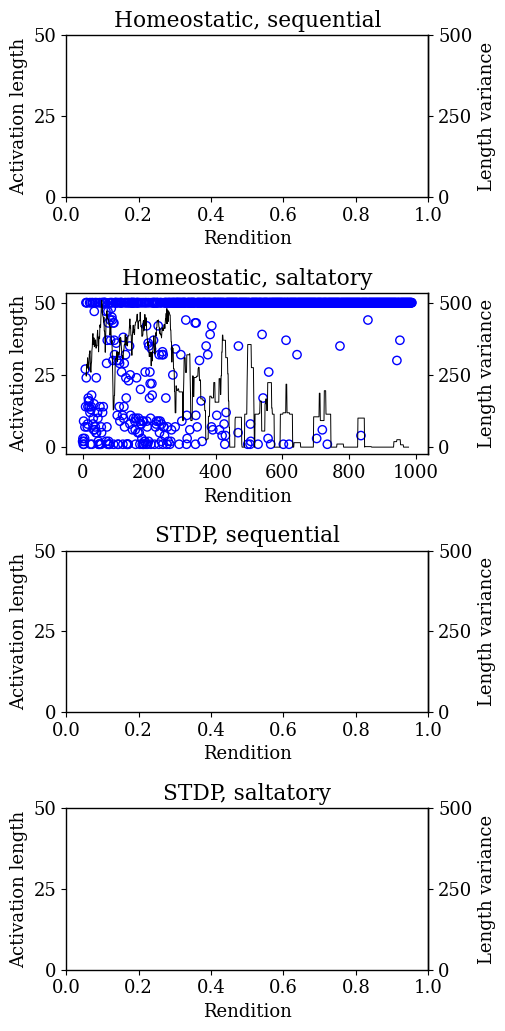

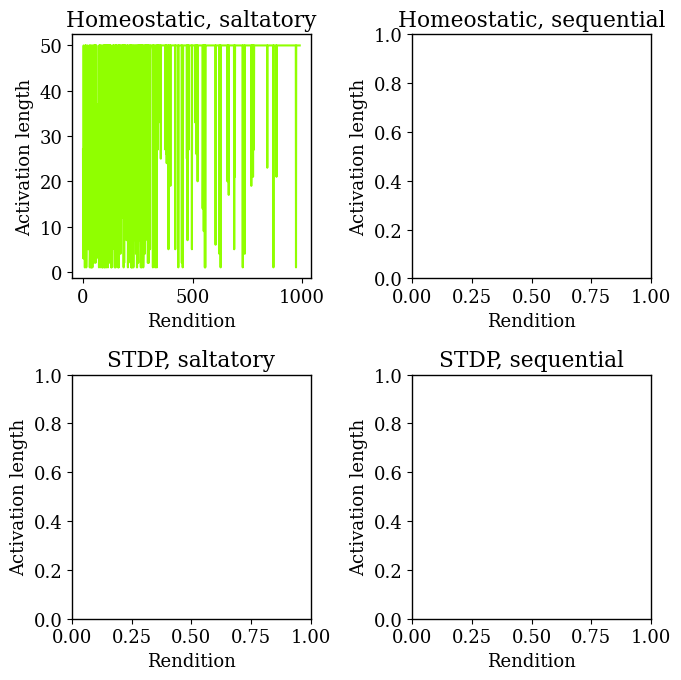

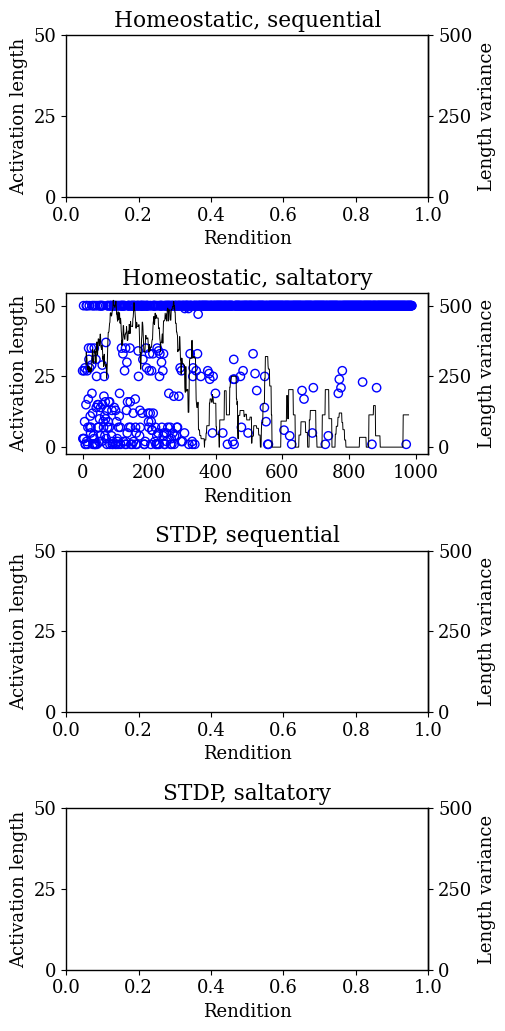

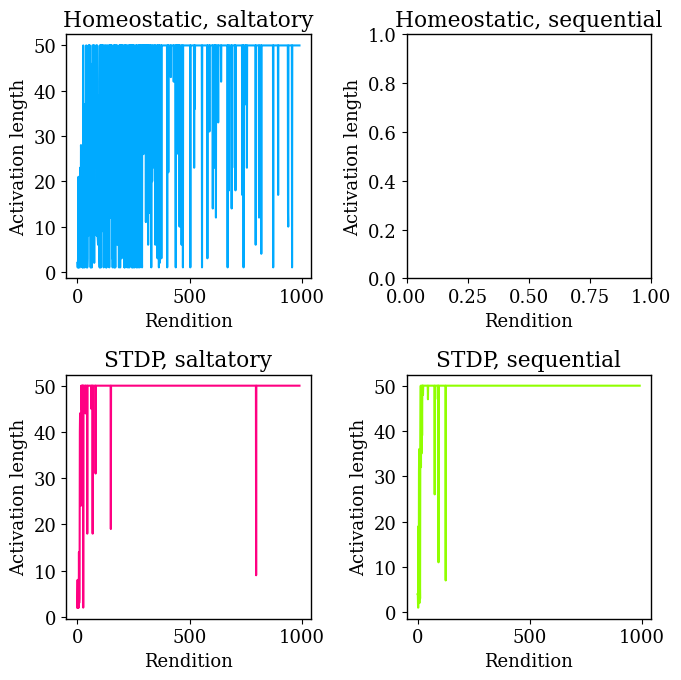

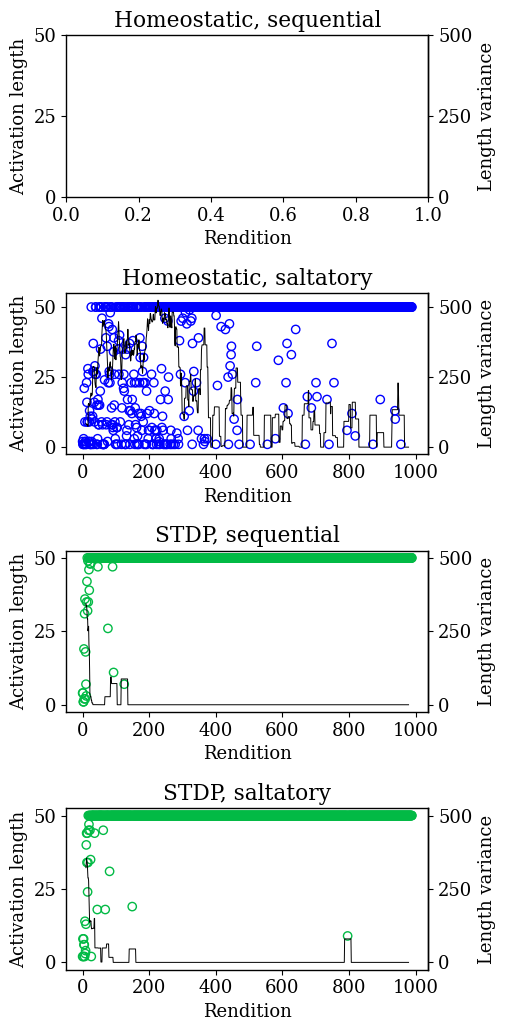

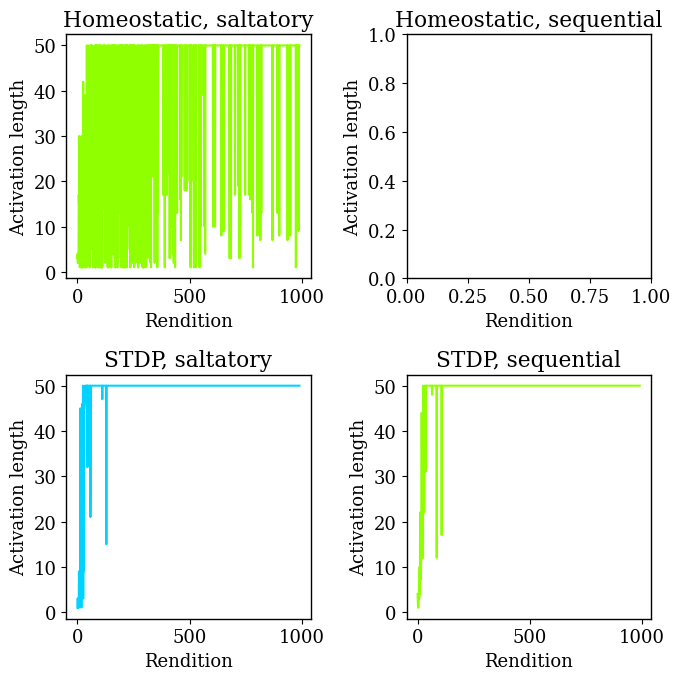

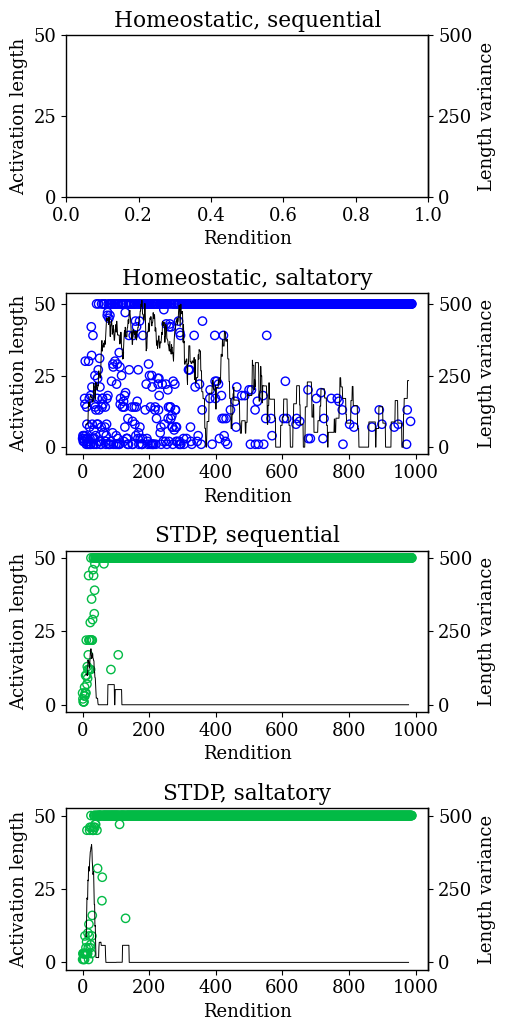

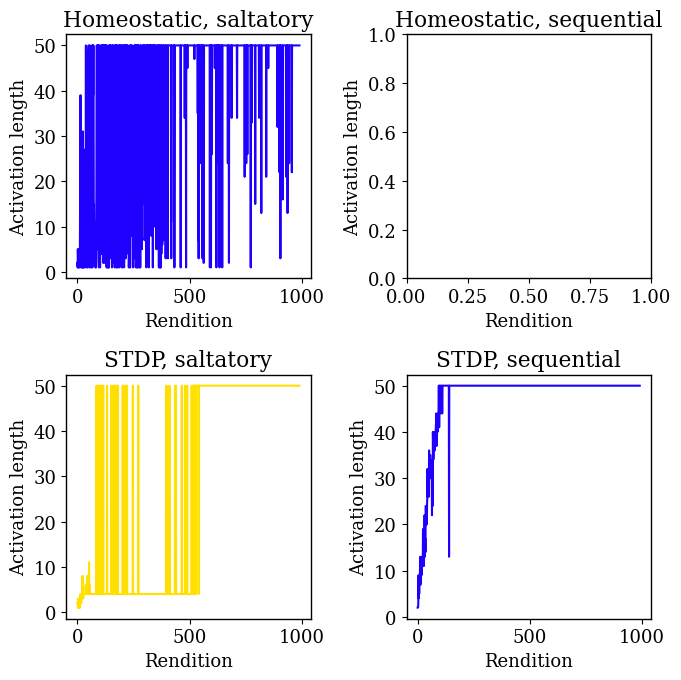

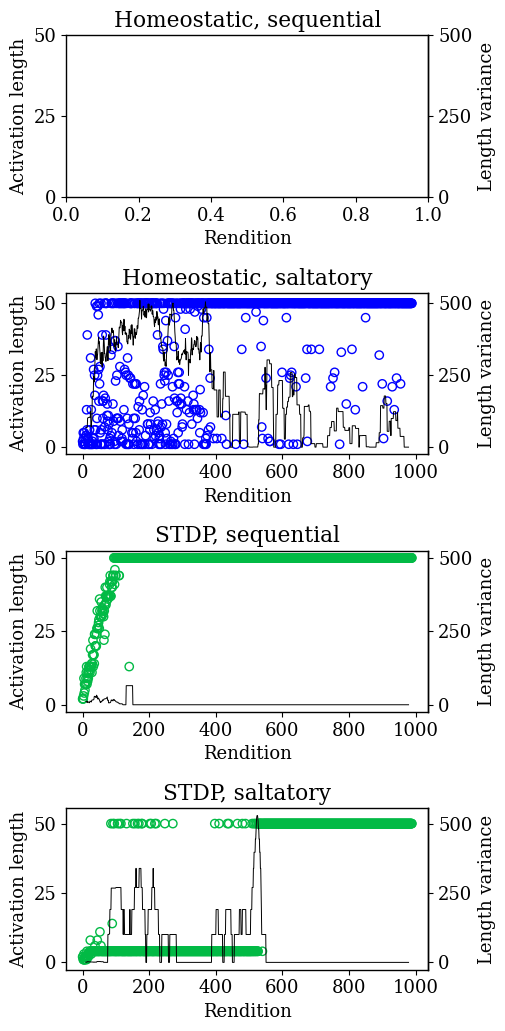

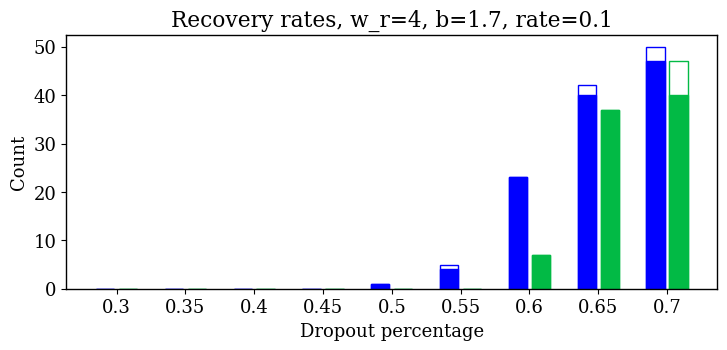

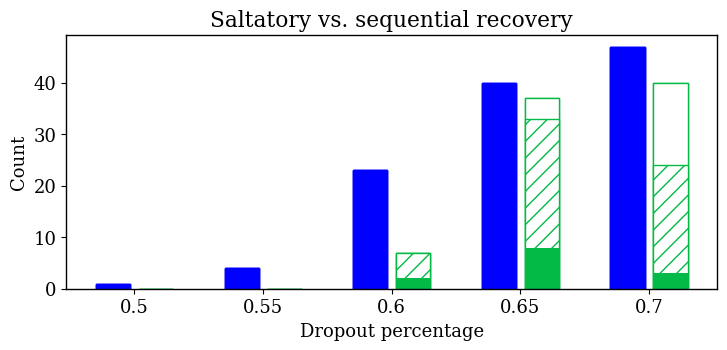

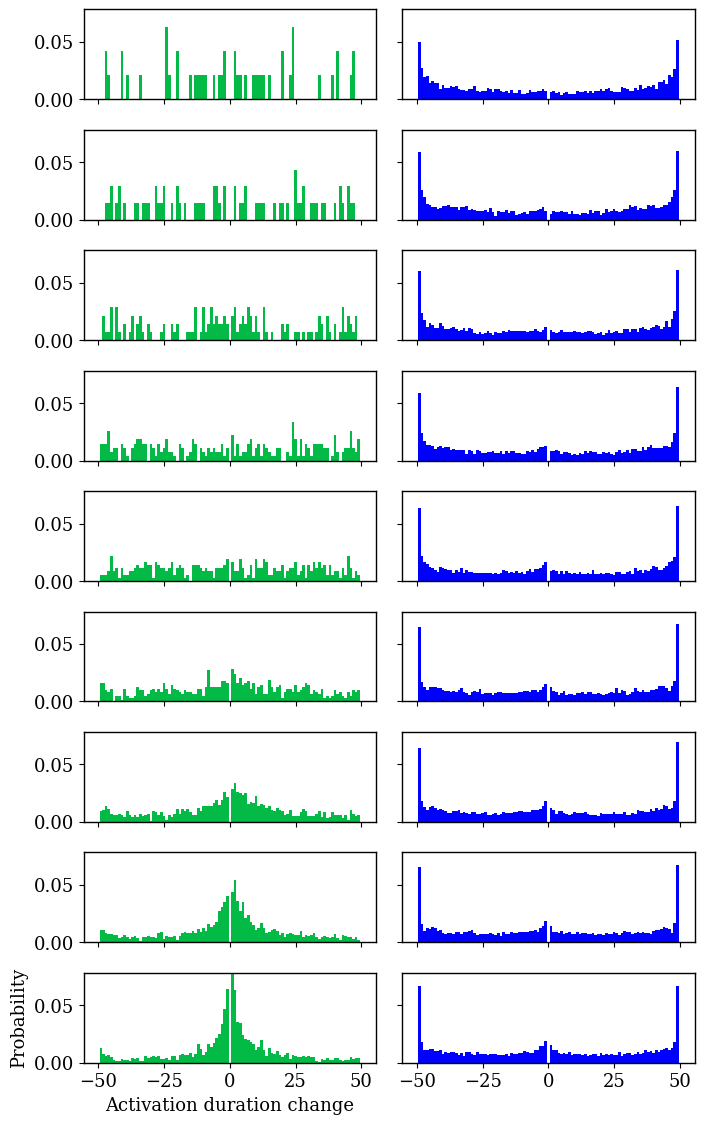

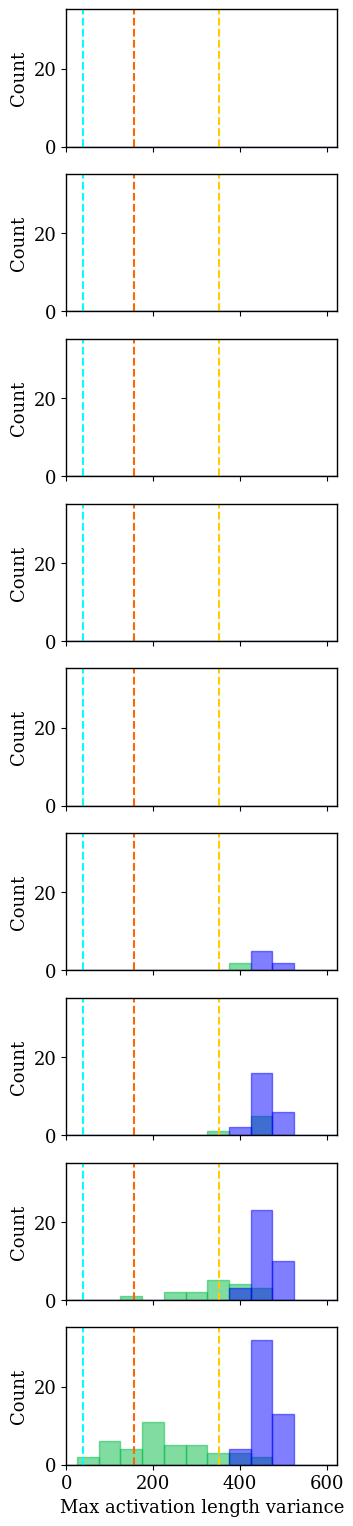

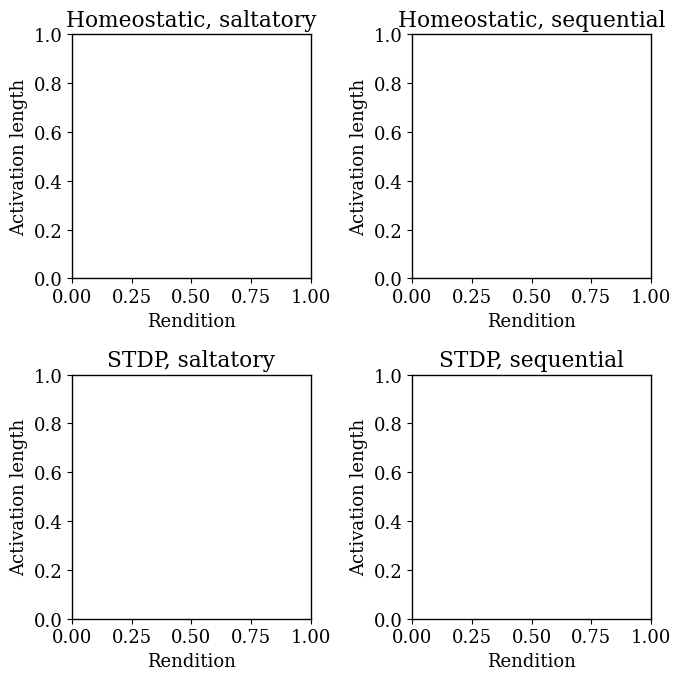

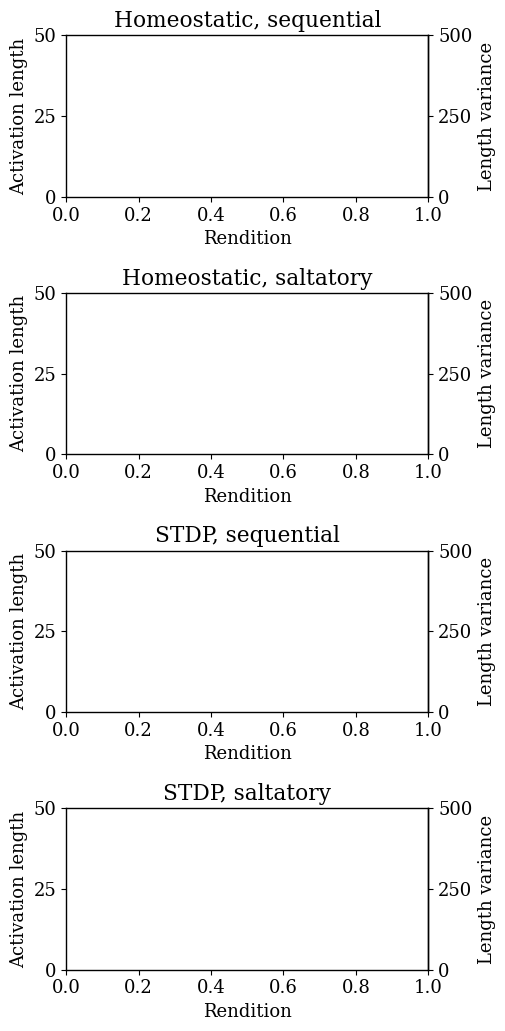

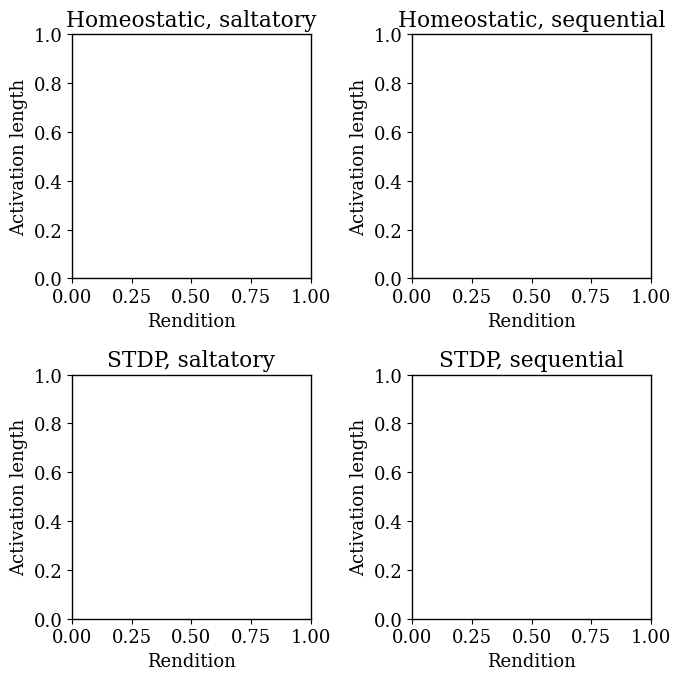

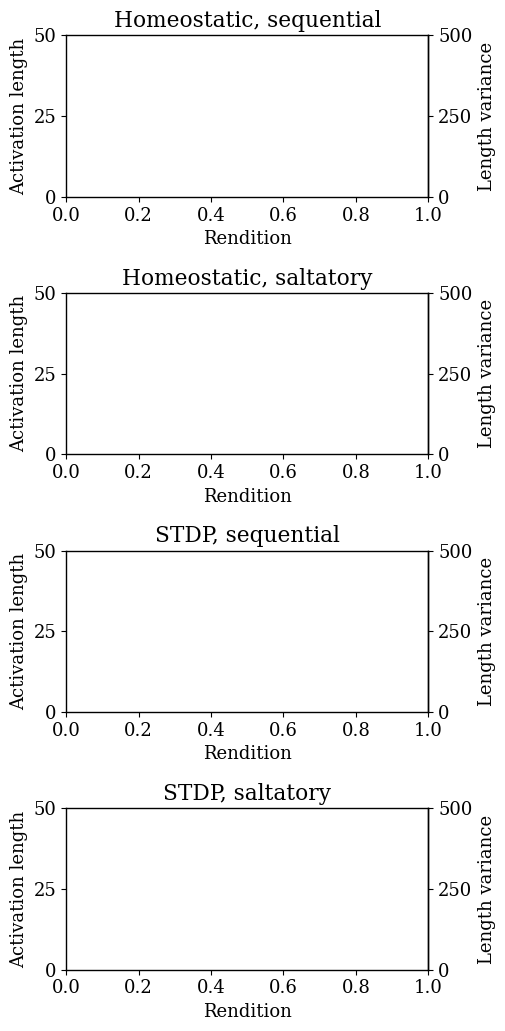

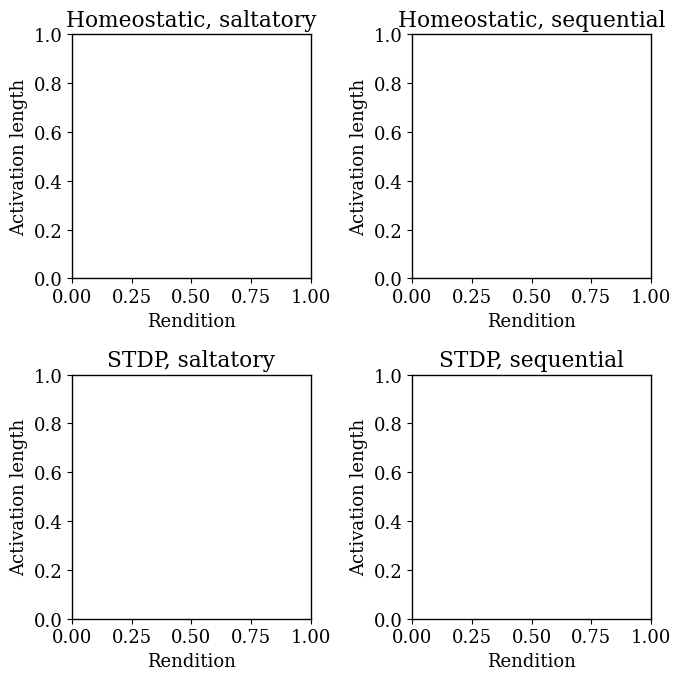

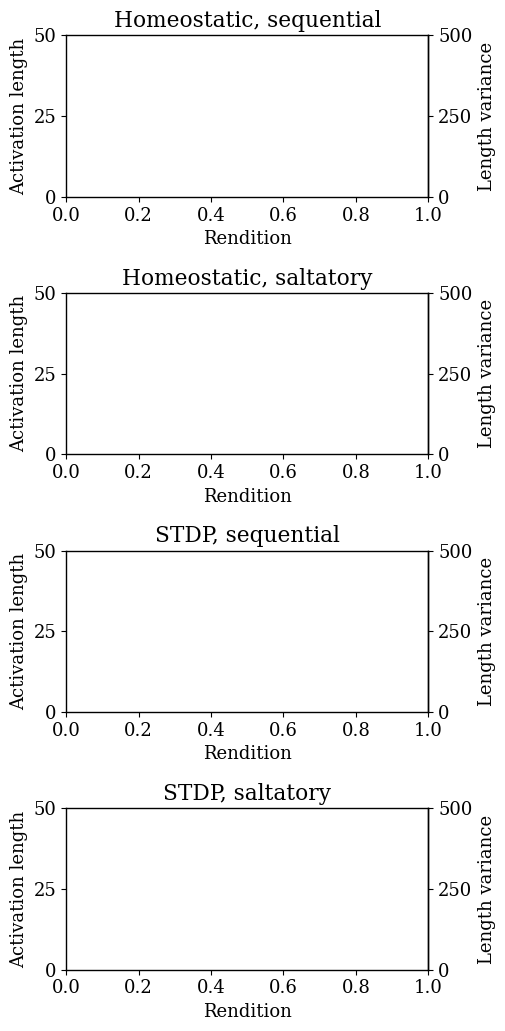

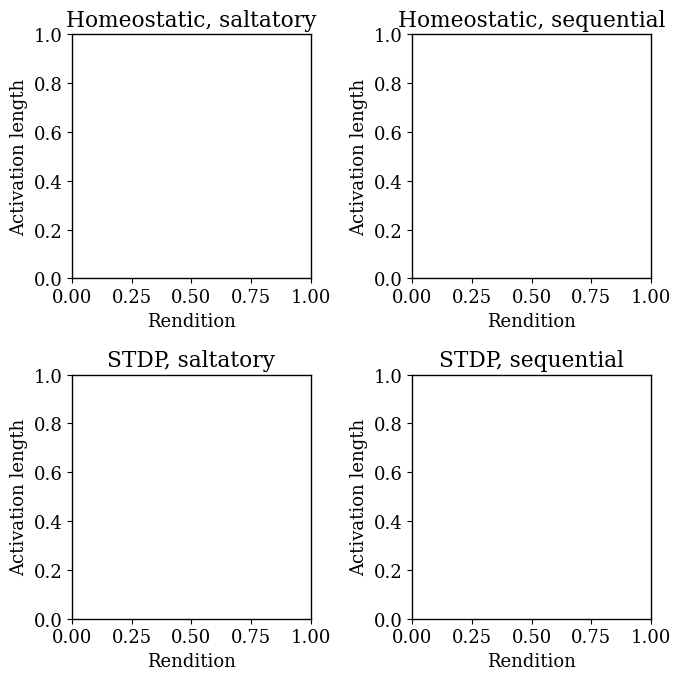

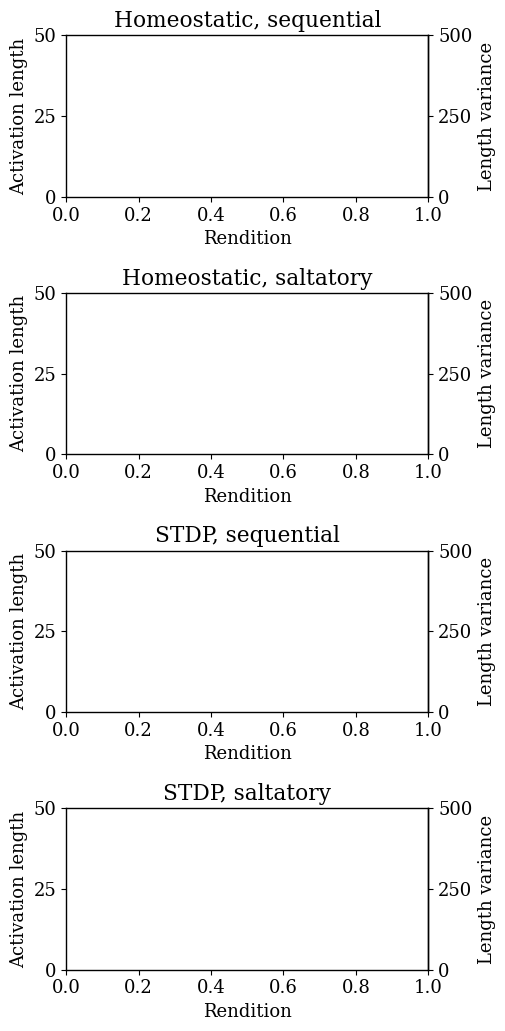

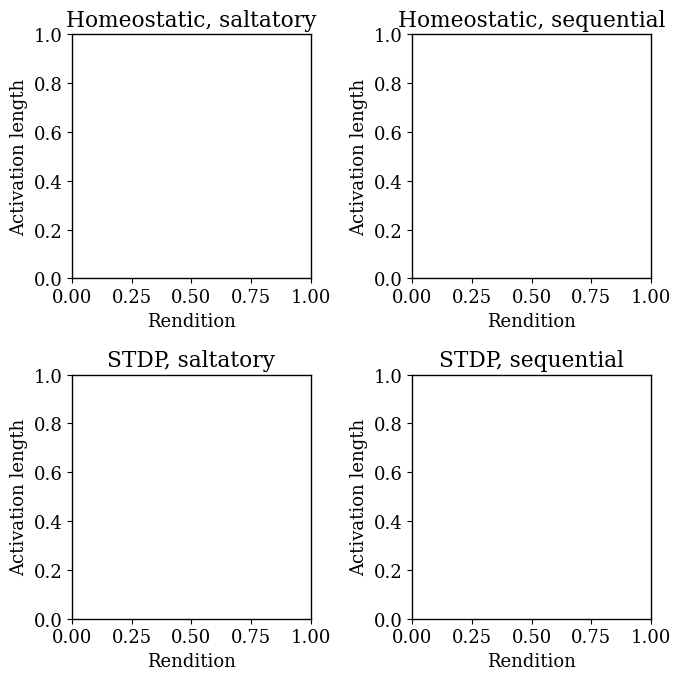

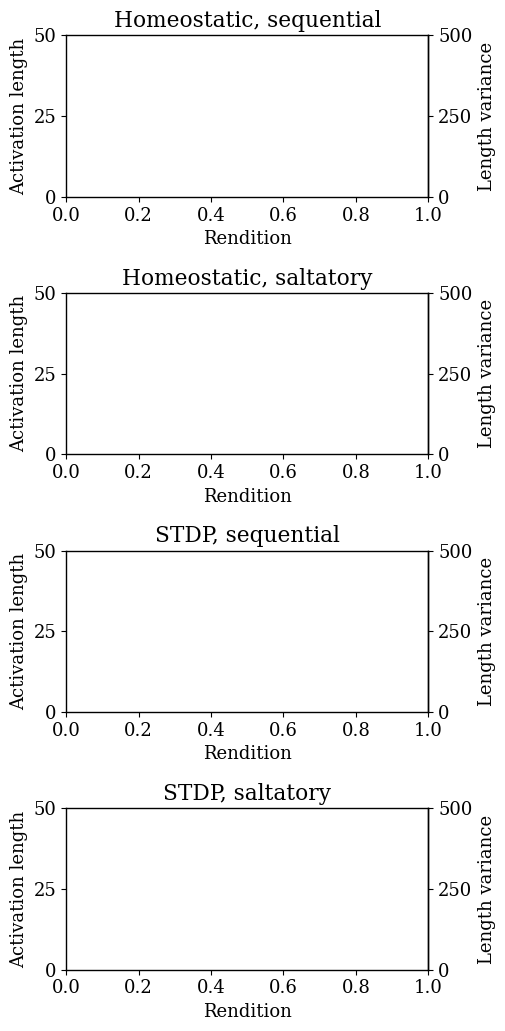

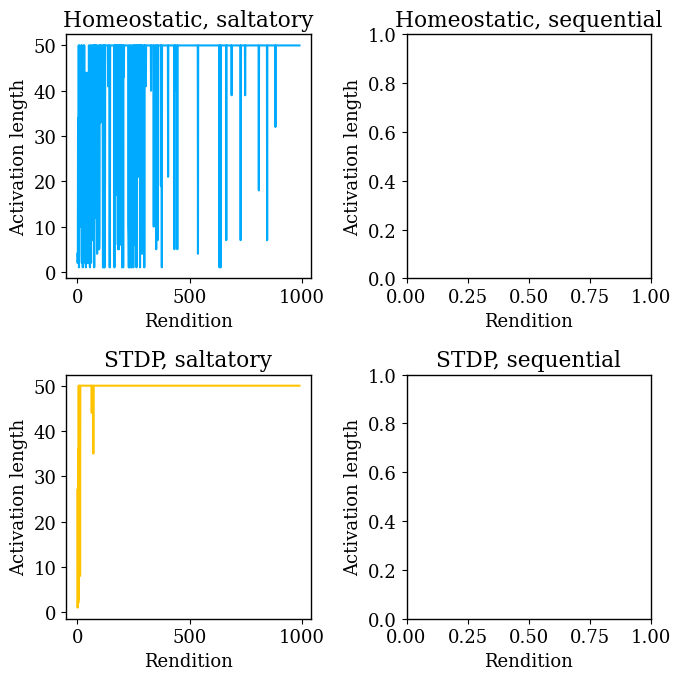

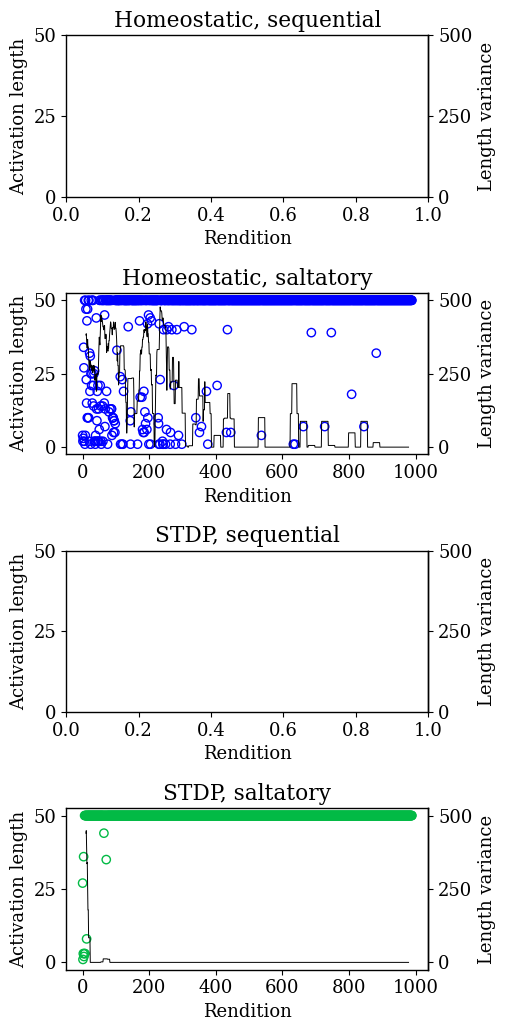

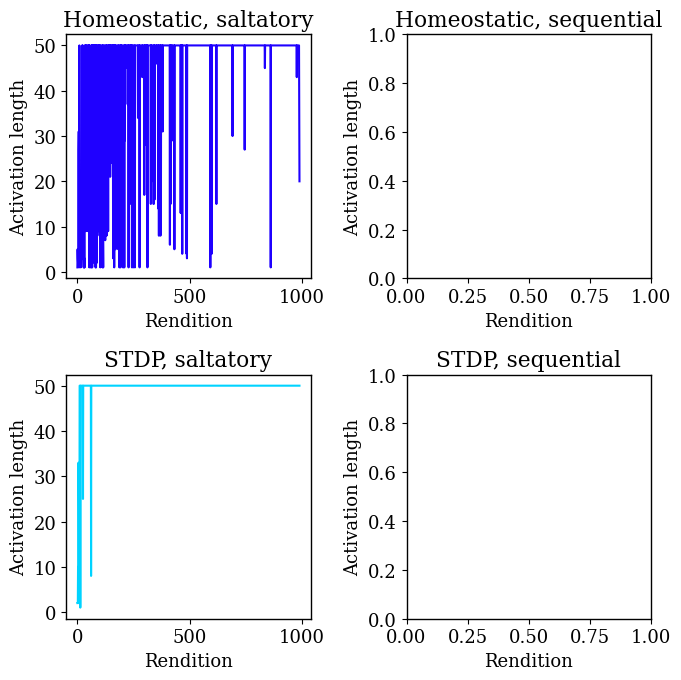

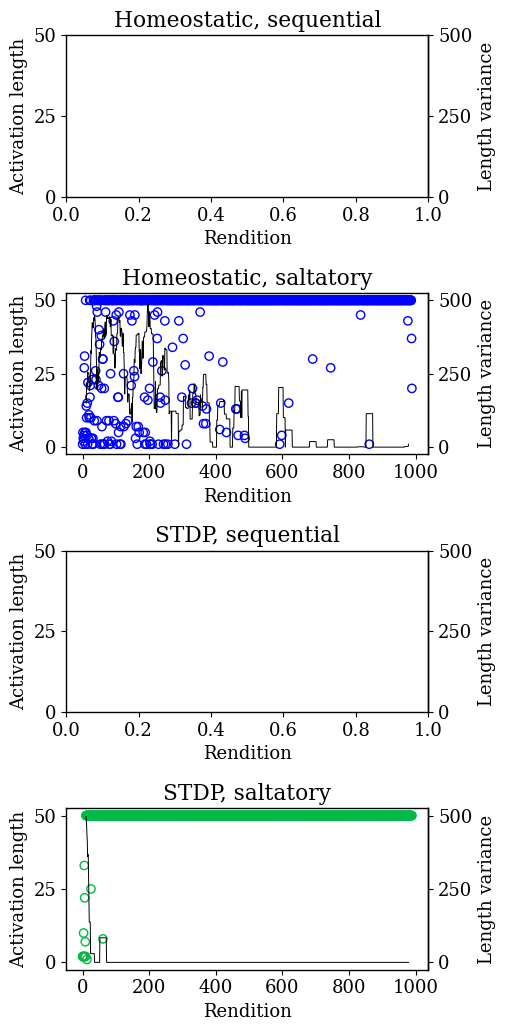

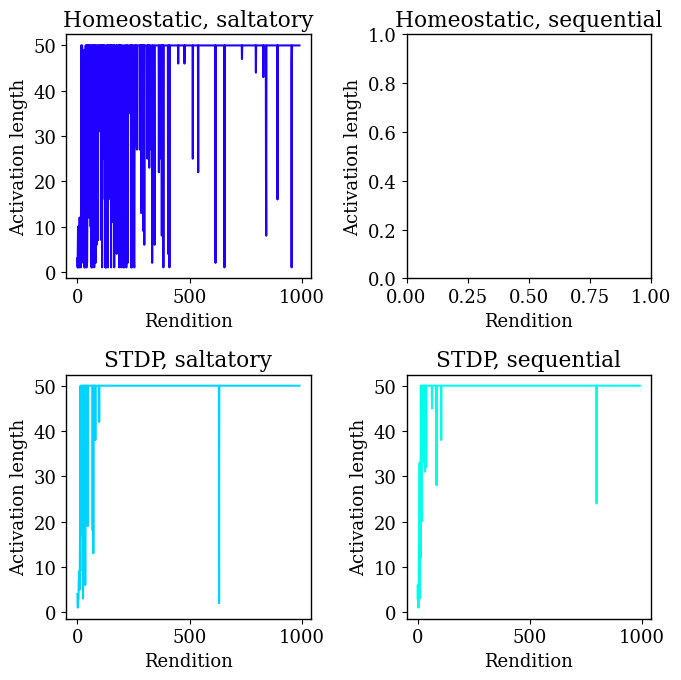

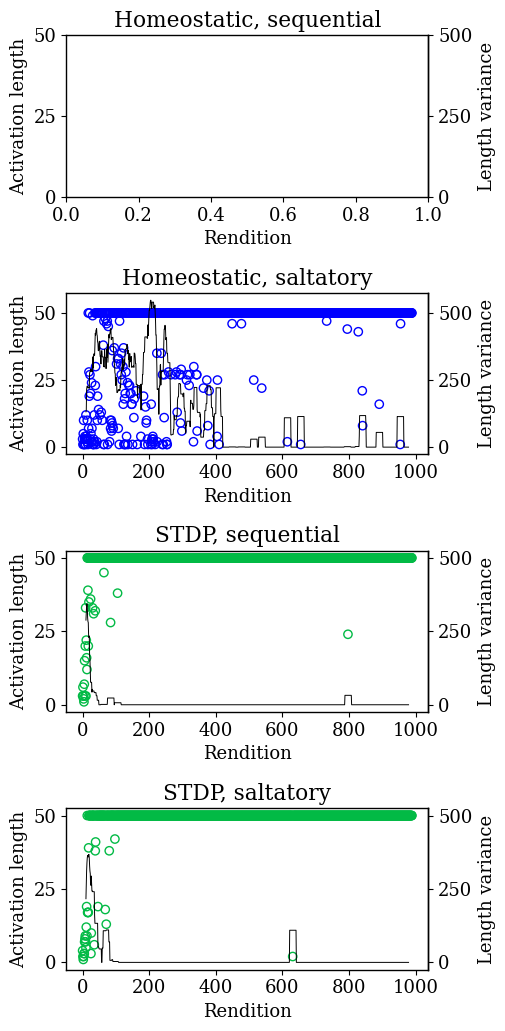

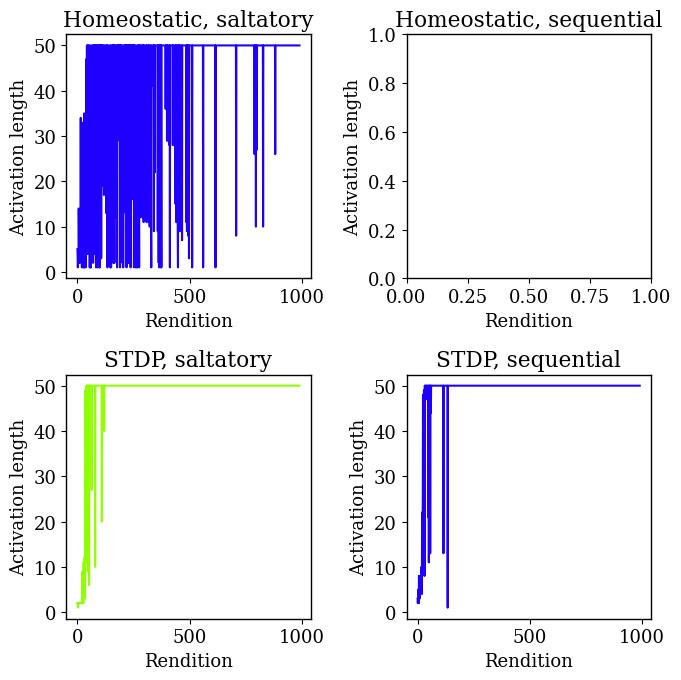

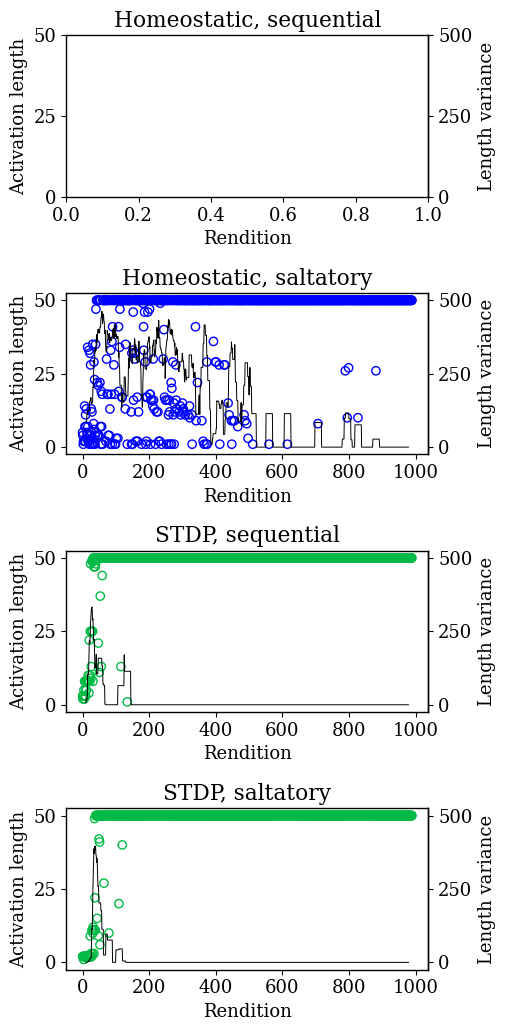

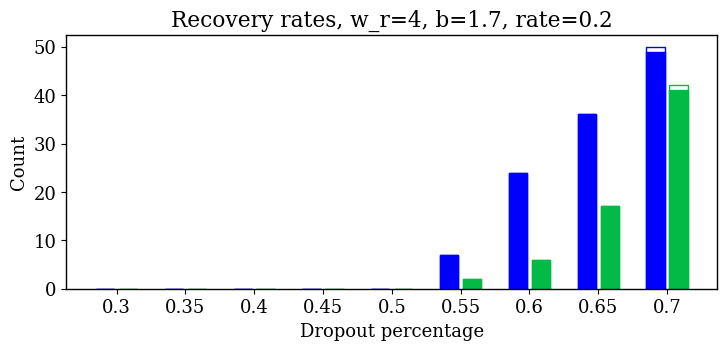

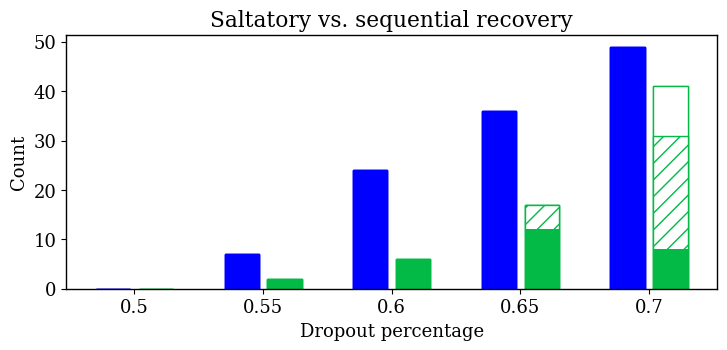

In [122]:
for i in range(0, len(df), 18):
    sub_df = df[i:i+18]
    df_homeostatic = sub_df[sub_df['rule'] == 'homeostatic']
    df_stdp = sub_df[sub_df['rule'] == 'stdp']

    a_shape = literal_eval(list(df_homeostatic['activations_shape'])[0])
    w_r = df_homeostatic['w_r'].iloc[0]
    b = df_homeostatic['b'].iloc[0]
    rate = df_homeostatic['rate'].iloc[0]

    activations_homeostatic = [np.array(a).reshape(a_shape) for a in list(df_homeostatic['activations'].apply(lambda x: json.loads(x)))]
    activations_stdp = [np.array(a).reshape(a_shape) for a in list(df_stdp['activations'].apply(lambda x: json.loads(x)))]

    plot_salt_vs_seq_statistics_2(activations_homeostatic, activations_stdp, subtitle=f', w_r={w_r}, b={b}, rate={rate}', plot_runs=True, bin_size=1, idx=i)